# t 

In [11]:
(2041)//64

31

In [20]:
# !ls /workspace/saved_models/brand_classifier/milk/resnet50/

In [21]:
# !rm -r /workspace/saved_models/brand_classifier/milk/resnet50/test

In [5]:
!mv /workspace/data/brand/* /workspace/product-classifier/data/

In [1]:
%%javascript
document.title='"SHELF.D-classification'

<IPython.core.display.Javascript object>

# IMPORTS 

In [23]:
#### import pickle
import os
import pickle
import re
import pathlib
import json
import h5py

import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

import keras
from keras.models import Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split 

import tensorflow_addons as tfa
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.engine.base_preprocessing_layer import PreprocessingLayer
from tensorflow.python.keras.engine import base_preprocessing_layer
from tensorflow.python.keras.utils import control_flow_util
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from abc import ABC, abstractmethod

import seaborn as sns

## downloaded model
<font color=blue>
    
<blockquote><b>EfficientNetB7 </b></blockquote>
<code>
tf.keras.applications.EfficientNetB7( 
     include_top=False, 
     weights="imagenet", 
     input_tensor=None, 
     input_shape=(224,224,3), 
     pooling=None,d 
     classes=1000, 
     classifier_activation="softmax", )
</code>

<br>
<blockquote><b>RES NET </b></blockquote>
<code>
tf.keras.applications.ResNet50( 
    include_top=False, 
    weights="imagenet", 
    input_tensor=None, 
    input_shape=(224,224,3), 
    pooling=None, 
    classes=1000)</code>

In [24]:
class RandomCutout(PreprocessingLayer):
    """Creates random mask on the image.
  Input shape:
    4D tensor with shape:
    `(samples, height, width, channels)`, data_format='channels_last'.
  Output shape:
    4D tensor with shape:
    `(samples, height, width, channels)`, data_format='channels_last'.
  Attributes:
    mask: A tuple or a list with two values `mask-height` and `mask-width`.
    seed: Integer. Used to create a random seed.
    name: A string, the name of the layer.
  Raise:
    ValueError: if mask is not a list or tuple of two values.
    InvalidArgumentError: if mask_size (mask_height x mask_width) can't be divisible by 2. 
  """
    def __init__(self, mask, seed=None, name=None, **kwargs):
        self.mask = mask
        if isinstance(mask, (tuple, list)) and len(mask) == 2:
            self.lower = mask[0]
            self.upper = mask[1]
            
        else:
            raise ValueError('RandomCutout layer {name} received an invalid mask '
                       'argument {arg}. only list or touple of size 2 should be passed'.format(name=name, arg=mask))

        self.seed = seed
        self.input_spec = InputSpec(ndim=4)
        super(RandomCutout, self).__init__(name=name, **kwargs)
        base_preprocessing_layer._kpl_gauge.get_cell('V2').set('RandomCutout')

    def call(self, inputs, training=True):
        if training is None:
            training = K.learning_phase()

        def random_cutout_inputs():
            return tfa.image.random_cutout(inputs, (self.lower, self.upper), constant_values = 0)

        output = control_flow_util.smart_cond(training, random_cutout_inputs,
                                              lambda: inputs)
        output.set_shape(inputs.shape)
        return output

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'mask': self.mask,
            'seed': self.seed,
        }
        
        base_config = super(RandomCutout, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

# CLASS model template

In [25]:
class BaseModel(ABC):
    def __init__(self, cfg):
        self.config = Config.from_json(cfg)

    @abstractmethod
    def load_data(self):
        pass

    @abstractmethod
    def build_model(self):
        pass

    @abstractmethod
    def train(self):
        pass

    @abstractmethod
    def evaluate(self):
        pass
    @abstractmethod
    def predict(self):
        pass

In [26]:
class Config:
    """Config class which contains data, train and model hyperparameters"""

    def __init__(self, data, train, model):
        self.data = data
        self.train = train
        self.model = model

    @classmethod
    def from_json(cls, cfg):
        """Creates config from json"""
        params = json.loads(json.dumps(cfg), object_hook=HelperObject)
        return cls(params.data, params.train, params.model)


class HelperObject(object):
    """Helper class to convert json into Python object"""
    def __init__(self, dict_):
        self.__dict__.update(dict_)

# CLASS classifier

In [27]:
# def data_loader():
    
#     train_datagen = ImageDataGenerator(rescale=1./255,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.2) # set validation split

#     train_generator = train_datagen.flow_from_directory(
#         train_data_dir,
#         target_size=(img_height, img_width),
#         batch_size=batch_size,
#         class_mode='binary',
#         subset='training') # set as training data

#     validation_generator = train_datagen.flow_from_directory(
#         train_data_dir, # same directory as training data
#         target_size=(img_height, img_width),
#         batch_size=batch_size,
#         class_mode='binary',
#         subset='validation') # set as validation data

#     model.fit_generator(
#         train_generator,
#         steps_per_epoch = train_generator.samples // batch_size,
#         validation_data = validation_generator, 
#         validation_steps = validation_generator.samples // batch_size,
#         epochs = nb_epochs)

In [464]:
class ResNet50(BaseModel):
    def __init__(self, cat, config, name_tensorboard):
        super().__init__(config)
        self.base_model = tf.keras.applications.ResNet50(
                            include_top=False,
                            weights="imagenet",
                            input_tensor=None,
                            input_shape=(224,224,3),
                            pooling=None,
                            classes=1000)
        self.name_tensorboard=name_tensorboard
        self.model= None
        # self.output_channels = self.config.model.output
        self.dataset = None                  
        # self.config=config
        self.info=None
        self.batch_size = self.config.train.batch_size
        # self.buffer_size = self.config.train.buffer_size
        self.epochs = self.config.train.epochs
        self.dropout = self.config.model.dropout
        self.lr = self.config.train.opt_lr
        # self.num_classes =  self.config.data.num_classes
        self.fine_tune_at=  self.config.train.fine_tune_at
        # self.val_subsplits = self.config.train.val_subsplits
        self.validation_steps = 0
        self.train_length = 0
        self.steps_per_epoch = 0
#         self.config=config
        
        self.cat = cat
        self.path_to_data = pathlib.Path(f'/workspace/data/brand/{cat}')
        self.model_path = pathlib.Path(f'/workspace/saved_models/brand_classifier/{self.cat}/{self.base_model.name}')
        
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        
    @staticmethod
    def lr_scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return lr * tf.math.exp(-0.1)


    @staticmethod
    def plot_history(history,
                     save=False ,
                     save_path='./train_validation.png'):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        plt.figure(figsize=(8, 8))
        plt.subplot(2, 1, 1)
        plt.plot(acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.ylabel('Accuracy')
        plt.ylim([min(plt.ylim()),1])
        plt.title('Training and Validation Accuracy')

        plt.subplot(2, 1, 2)
        plt.plot(loss, label='Training Loss')
        plt.plot(val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.ylabel('Cross Entropy')
        plt.ylim([0,5.0])
        plt.title('Training and Validation Loss')
        plt.xlabel('epoch')
        if save:
            plt.savefig(save_path, dpi=300)
            print('plot_saved')
            print('save_path\n',save_path)
        plt.show()
    
    
        return plt.gcf()
        
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    @staticmethod
    def preprocessing_fun(img):
        dst = cv2.fastNlMeansDenoisingColored(img.astype(np.uint8), None, 10, 10, 7, 21)
#         print('image denoised')
        return dst
    
    @staticmethod
    def data_augment():
        inputs = tf.keras.Input(shape=(224, 224, 3))
        data_augmentation = keras.Sequential(
            [
#                   tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
#                 tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
                  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
                  tf.keras.layers.experimental.preprocessing.RandomContrast(0.5),
#                   tf.keras.layers.experimental.preprocessing.RandomZoom(0.4),
                tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
                RandomCutout((224,20)),
        #           tf.keras.layers.experimental.preprocessing.RandomCrop(224,224,),
        #         tf.keras.layers.experimental.preprocessing.Rescaling(),
            ]
        )
        return data_augmentation(inputs)
        
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    
    def load_data_from_dir(self,train_data_dir = '/workspace/data/brand/milk/train-val',
                   test_data_dir = '/workspace/data/brand/milk/test'):
        img_height = 224
        img_width=224
        batch_size = self.batch_size
        list_clasess = sorted({x for x in os.listdir(train_data_dir) if re.search('[0-9]+', x)})
        num_samples = len(list(pathlib.Path(train_data_dir).rglob('*.jpg')))

        test_datagen = ImageDataGenerator(
#             rescale=1./255,
        )

        validation_datagen = ImageDataGenerator(
#             rescale=1./255,
              validation_split=0.2)

        train_datagen = ImageDataGenerator(
#             rescale=1./255,
            shear_range=0.2,
            zoom_range=0.4,
            fill_mode="nearest",
            zca_whitening=False,
            width_shift_range=0.2,
            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=False,
#             preprocessing_function=ResNet50.preprocessing_fun,
            validation_split=0.2) # set validation split

        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            shuffle=True,
            target_size=(img_height, img_width),
            seed=1,
            classes=list_clasess,
            batch_size=batch_size,
            class_mode='categorical',
            subset='training') # set as training data

        validation_generator = validation_datagen.flow_from_directory(
            train_data_dir, # same directory as training data
            shuffle=True,
            target_size=(img_height, img_width),
            batch_size=batch_size,
            seed=1,
            classes=list_clasess,
            class_mode='categorical',
            subset='validation') # set as validation data

        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            shuffle=False,
            target_size=(img_height, img_width),
            seed=1,
            batch_size=1,
            classes=list_clasess,
            class_mode='categorical',
                )
        
        self.dataset = dict([('train', train_generator),
                    ('validation', validation_generator),
                    ('test',test_generator),
                    ('num_classes',train_generator.num_classes),
                    ('mapping', train_generator.class_indices),
                    ('total_train_val_samples', num_samples )
                            ])
#         return train_generator, validation_generator, test_generator

        # model.fit_generator(
        #     train_generator,
        #     steps_per_epoch = train_generator.samples // batch_size,
        #     validation_data = validation_generator, 
        #     validation_steps = validation_generator.samples // batch_size,
        #     epochs = nb_epochs)

    def load_data(self):
#         with open(self.path_to_data / 'x_all.pickle', 'rb') as writer_x,\
#              open(self.path_to_data / 'y_all.pickle', 'rb') as writer_y:
#             x = pickle.load(writer_x)
#             y = pickle.load(writer_y)
        with h5py.File(self.path_to_data / 'xy.h5' , 'r') as reader:
            print('loading...')
            print(f'keys ::: {reader.keys()}')
            x = np.array(reader['x'],dtype='uint8')
            y = np.array(reader['y'],dtype='int64')            
        
        
        
        
#         mapping = list(zip([y,
#                             pd.Series(y).astype('category').cat.codes]))
#         import pdb;pdb.set_trace()
        y = pd.Series(y).astype('category')
        
        df_mapping =pd.DataFrame(data=[y, pd.Series(y).astype('category').cat.codes.values])
        df_mapping = df_mapping.T.drop_duplicates()
        
        y = y.cat.codes
        
        y = np.array(y)
        x = np.array(x)
        x_train, x_validation, y_train, y_validation =\
                        train_test_split(x,
                                         y,
                                         test_size=0.2,
                                         random_state=1)
    
        
        num_classes = len(set(y))
        
        y_train = keras.utils.to_categorical(y_train, num_classes)
        
        y_validation = keras.utils.to_categorical(y_validation, num_classes)
        
        # instead of normalizing use pre_process 
#         x_train = preprocess_input(x_train)
#         x_validation = preprocess_input(x_validation)
        
        self.dataset = dict([('train', (x_train,y_train)),
                    ('validation', (x_validation, y_validation)),
                    ('num_classes',num_classes),
                    ('mapping', df_mapping)])
        
        
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

    
    def build_model(self, num_classes):
        inputs = tf.keras.Input(shape=(224, 224, 3))

#         x = self.data_augment(inputs)
        x = preprocess_input(inputs)
    
        x = self.base_model(x, training=False) # As previously mentioned, use training=False as our model contains a BatchNormalization layer.
        
        global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
        x = global_average_layer(x)
        
        x = tf.keras.layers.Dropout(self.dropout)(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dropout(self.dropout)(x)
        x = tf.keras.layers.Dense(128, activation='relu')(x)
        x = tf.keras.layers.Dropout(self.dropout)(x)
        x = tf.keras.layers.Dense(num_classes//2, activation='relu')(x)
        
        prediction_layer = tf.keras.layers.Dense(num_classes,activation='softmax')
        
        outputs = prediction_layer(x)
        
        
        self.model = tf.keras.Model(inputs, outputs)
        
        return 
        
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    def callbacks(self,):
        lr_callback = LearningRateScheduler(self.lr_scheduler)
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
                                log_dir=self.model_path / 'logs' / self.name_tensorboard,
                                histogram_freq=0,
                                write_graph=True,
                                write_images=False,
                                update_freq="epoch",
                                profile_batch=2,
                                embeddings_freq=0,
                                embeddings_metadata=None,
                            )
        save_checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(
                    self.model_path /  'checkpoints' / f'{self.name_tensorboard}' / 'weights.{epoch:02d}-{val_loss:.2f}.hdf5' ,
                    monitor='val_loss', verbose=0, save_best_only=True,
                    save_weights_only=False, mode='auto', save_freq='epoch',
                    options=None
                )
        return [lr_callback,
                tensorboard_callback,
               save_checkpoint_callback]
    
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    def compile_model(self, fine_tune_at=None, lr = None):
        self.base_model.trainable = True
        learning_rate = lr if lr else self.lr
        ft = fine_tune_at if fine_tune_at else self.fine_tune_at
        for layer in self.base_model.layers[:ft]:
            layer.trainable =  False
            
        print('len(self.model.trainable_variables) ', len(self.model.trainable_variables))
        self.model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy',
#                       tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(), 
                      tf.keras.metrics.Recall()
#                       tf.keras.metrics.SparseCategoricalCrossentropy()
                      ],)
        print(self.model.optimizer.get_config())
    
    
    def train(self,
              data,
              save=False,
              epochs = None,
              save_name='no_name',
              initial_epoch=0,
              verbose=1
             ):
        
        epochs = epochs if epochs else self.epochs 
        history = self.model.fit(self.dataset['train'],
                                 batch_size=self.batch_size,
                                 epochs=epochs,
                                 initial_epoch = initial_epoch,
                                 validation_data=self.dataset['validation'],
                                 callbacks= self.callbacks(),
                                 verbose=verbose,
                                 steps_per_epoch=self.dataset['total_train_val_samples'] // self.batch_size,
                                 workers=4,
                           )
#         history = self.model.fit(self.dataset['train'][0],
#                                  self.dataset['train'][1],
#                          batch_size=self.batch_size,
#                          epochs=self.epochs,
#                          initial_epoch = initial_epoch,
#                          validation_data=(self.dataset['validation'][0], self.dataset['validation'][1]),
#                          callbacks= self.callbacks(),
#                          verbose=verbose,
#                          workers=4,
#                    )
        
        if save:
            if not os.path.exists(self.model_path / save_name):
                os.makedirs(self.model_path / save_name)
            self.model.save(self.model_path / save_name)
            plot = self.plot_history(history, save=True,
                                     save_path= self.model_path / save_name/ 'cross_val.png')
            mapping = self.dataset['mapping']
            mapping = pd.DataFrame.from_dict(mapping, orient='index')
            mapping.columns = ['code']
            mapping.index.name = 'vms'
            mapping.to_csv(self.model_path / save_name/ 'vms_code_mapping.csv')
            print('saved')
        else:
            plot = self.plot_history(history,save=False)
            
        return history
        
        
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   
    def evaluate(self):
        preds = []
        self.model.evaluate(
                        self.dataset['test'],
                        batch_size=None,
                        verbose=1,
                        sample_weight=None,
                        steps=None,
                        callbacks=None,
                        max_queue_size=10,
                        workers=1,
                        use_multiprocessing=False,
                        return_dict=False,
                        )
        
    
    def predict(self, image):
        return self.model.predict(image)
    
    
    def load_from_checkpoint(self, p):
        self.load_data_from_dir()
        self.build_model(self.dataset['num_classes'])
        self.compile_model()
        self.model.load_wieghts(p)
    

# edit config for test 

In [472]:
CFG =\
{
   "data": {
       "path": "path",
       "image_size": 224,
       "load_with_info": True
   },
   "train": {
       "batch_size": 64,
       "buffer_size": 1000,
       "epochs": 35,
       "fine_tune_at":120,
       "opt_lr":0.0001,
       "val_subsplits": 5,
       "optimizer": {
           "type": "adam"
       },
       "metrics": ["accuracy"]
   },
    "model": {
        "input": [128, 128, 3],
        "dropout" : 0.3,
        "up_stack": {
            "layer_1": 512,
            "layer_2": 256,
            "layer_3": 128,
            "layer_4": 64,
            "kernels": 3
        },
        "output": 3
    }
}
# with open('config.json', 'w') as writer:
#     json.dump(CFG, writer)

# DEFINE BUILD RUN SAVE

In [473]:
# from configs.config import CFG

In [10]:
import pathlib
n,d = '1', 'v'
pathlib.Path('/workspace/saved_models/') /  'checkpoints' / f'{n}' / f'{d}'

PosixPath('/workspace/saved_models/checkpoints/1/v')

In [12]:
# filepath = "/workspace/saved_models/brand_classifier/milk/resnet50/logs/"
filepath = "/workspace/saved_models/brand_classifier/milk/resnet50/checkpoints"
# !rm -r  $filepath
!ls $filepath

# !rm -r /workspace/saved_models/brand_classifier/milk/resnet50/100_epoch___fine_tune_at_80_D/

In [475]:
model = ResNet50(cat='milk',
                 config= CFG,
                name_tensorboard='freeze_up_to_120_lr0001')
print('len(base_model.layers) :\n',len(model.base_model.layers))

len(base_model.layers) :
 175


In [476]:
# !mv  -v /workspace/data/brand/milk/train-val/138699/* /workspace/data/brand/milk/train-val/172276

In [477]:
# dd = model.load_data()
dd = model.load_data_from_dir()
model.dataset.keys()

Found 8429 images belonging to 139 classes.
Found 2041 images belonging to 139 classes.
Found 61 images belonging to 139 classes.


dict_keys(['train', 'validation', 'test', 'num_classes', 'mapping', 'total_train_val_samples'])

In [478]:
# from itertools import islice
# for batch in islice(model.dataset['train'],1):
#     for im in batch[0]:
#         plt.imshow(im.astype(np.uint8))
#         plt.show()

## WARM UP top layers

In [479]:
model.build_model(num_classes=model.dataset['num_classes'],)

In [480]:
model.compile_model(fine_tune_at=None, lr=None)

len(self.model.trainable_variables)  74
{'name': 'Adam', 'learning_rate': 0.0001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [481]:
# model.model.load_weights('/workspace/saved_models/brand_classifier/milk/resnet50/checkpoints/weights.25-0.56.hdf5',)

In [482]:
model.evaluate()

61/61 [==============================] - 3s 13ms/step - loss: 5.5763 - accuracy: 0.0000e+00 - precision_33: 0.0000e+00 - recall_33: 0.0000e+00


In [483]:
history = model.train(model.dataset['train'], save=False,
#                       initial_epoch=history.epoch[-1],
#                       save_name='6_epoch_0001_lr_finetune80',
                     )

Epoch 1/35
163/163 [==============================] - 47s 261ms/step - loss: 4.3655 - accuracy: 0.1091 - precision_33: 0.8497 - recall_33: 0.0609 - val_loss: 3.0456 - val_accuracy: 0.3900 - val_precision_33: 0.9693 - val_recall_33: 0.2788


KeyError: 'Failed to format this callback filepath: "/workspace/saved_models/brand_classifier/milk/resnet50/checkpoints/{self.name_tensorboard}/weights.{epoch:02d}-{val_loss:.2f}.hdf5". Reason: \'self\''

In [434]:
model.compile_model(fine_tune_at=80, lr=0.00005)

len(self.model.trainable_variables)  124
{'name': 'Adam', 'learning_rate': 5e-05, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}


In [435]:
model.evaluate()

61/61 [==============================] - 3s 12ms/step - loss: 0.0292 - accuracy: 0.9922 - precision_31: 0.9922 - recall_31: 0.9922


Epoch 15/35
163/163 [==============================] - 50s 277ms/step - loss: 0.5238 - accuracy: 0.8314 - precision_31: 0.8867 - recall_31: 0.7840 - val_loss: 0.5424 - val_accuracy: 0.8824 - val_precision_31: 0.9149 - val_recall_31: 0.8687
Epoch 16/35
163/163 [==============================] - 45s 271ms/step - loss: 0.3992 - accuracy: 0.8726 - precision_31: 0.9106 - recall_31: 0.8363 - val_loss: 0.5119 - val_accuracy: 0.8932 - val_precision_31: 0.9224 - val_recall_31: 0.8741
Epoch 17/35
163/163 [==============================] - 46s 276ms/step - loss: 0.3390 - accuracy: 0.8876 - precision_31: 0.9170 - recall_31: 0.8608 - val_loss: 0.4857 - val_accuracy: 0.8951 - val_precision_31: 0.9257 - val_recall_31: 0.8795
Epoch 18/35
163/163 [==============================] - 45s 274ms/step - loss: 0.3067 - accuracy: 0.8940 - precision_31: 0.9209 - recall_31: 0.8722 - val_loss: 0.4631 - val_accuracy: 0.9020 - val_precision_31: 0.9265 - val_recall_31: 0.8898
Epoch 19/35
163/163 [===================

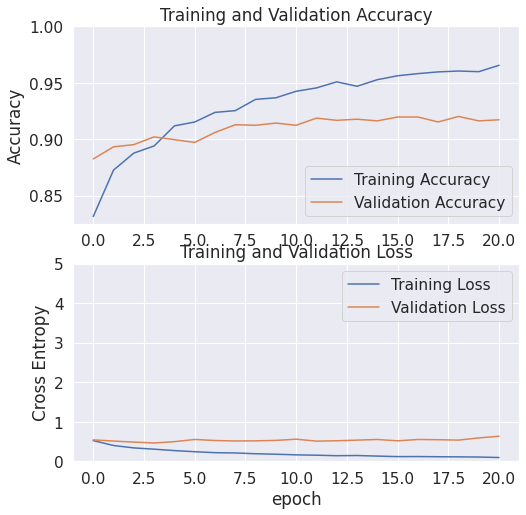

saved


<Figure size 432x288 with 0 Axes>

In [436]:
history1 = model.train(model.dataset['train'], save=True,
                      initial_epoch=history.epoch[-1],
                       epochs = 35,
                      save_name='finetune_at80_35epoch',
                     )

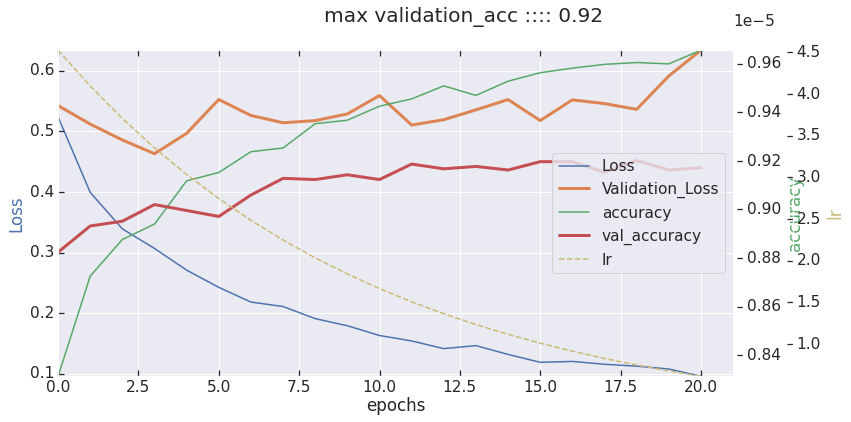

In [439]:
history_df = pd.DataFrame([*history1.history.values()], index = history1.history.keys()
            ).T
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

subtitle = f'max validation_acc :::: {history_df.val_accuracy.max().round(3)}'

plt.figure(figsize=(15,6))
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))


par2.axis["right"].toggle(all=True)

new_fixed_axis = par1.get_grid_helper().new_fixed_axis
par1.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par1,
                                    offset=(offset-50, 0))

par1.axis["right"].toggle(all=True)

host.set_xlim(0, history_df.shape[0])
# host.set_ylim(0, 10)

host.set_xlabel("epochs")
host.set_ylabel("Loss")
par1.set_ylabel("accuracy")
par2.set_ylabel("lr")

p1, = host.plot(history_df.loss, label="Loss")
p2, = host.plot(history_df.val_loss, label="Validation_Loss", linewidth=3)

p3, = par1.plot(history_df.accuracy, label="accuracy")

p4, = par1.plot(history_df.val_accuracy, label="val_accuracy", linewidth=3)

p5, = par2.plot(history_df.lr,'--y', label="lr" )




host.set_ylim(np.concatenate([history_df.val_loss,history_df.loss] ).min(),
              np.concatenate([history_df.val_loss,history_df.loss]).max() )
par1.set_ylim(np.concatenate([history_df.val_accuracy,history_df.accuracy] ).min(),
              np.concatenate([history_df.val_accuracy,history_df.accuracy] ).max())
par2.set_ylim(history_df.lr.min(), history_df.lr.max())

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p3.get_color())
par2.axis["right"].label.set_color(p5.get_color())
fig = plt.gcf()
fig.suptitle(subtitle,
#              fontsize=32,va='bottom',
#              ha='right'
            )
plt.draw()
plt.show()


# REsult on TEST set

In [25]:
test_data_dir = '/workspace/data/brand/milk/test'

In [438]:
model.model.evaluate(model.dataset['test'])

61/61 [==============================] - 1s 13ms/step - loss: 0.0070 - accuracy: 1.0000 - precision_31: 1.0000 - recall_31: 1.0000


[0.0069539546966552734, 1.0, 1.0, 1.0]

In [121]:
p = model.model.predict(model.dataset['test'])
np.argmax(p,axis=1)

array([16, 16, 16, 16, 16, 16, 16, 16, 23, 23, 23, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
       53, 53, 53, 53, 53, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59,
       59, 59, 59, 59, 95, 95, 95, 95, 95, 95])

In [28]:
MM =model.dataset['mapping']
MM = pd.DataFrame.from_dict(MM, orient='index')
MM.index.name = 'vms'
MM.columns = ['code']
MM[MM['code']==127]

code
vms        
49092   127

# TODO

    * visualize prediction True label , Prediction . vms . snapp title . 
    * learning rate finder
    


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='lr', ylabel='loss'>

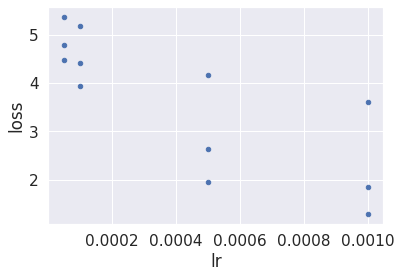

In [198]:
# # df_log = df_log.append(log)
# df_log.plot(x='lr', y='loss', kind='scatter',)

## unfreeze some layers and continue training 

In [59]:
# # history2 = model.train(model.dataset, save=False,
# #                       initial_epoch=history.epoch[-1],
# # #                       save_name='100_epoch__fine_tune_at_50',
# #                      )

# history_df = pd.DataFrame([*history.history.values()], index = history.history.keys()
#             ).T
# history2_df = pd.DataFrame([*history2.history.values()], index = history2.history.keys()
#             ).T
# history2_df.columns = history_df.columns 

# history_df = history_df.assign(epochs = list(range(1,16)))
# history2_df = history2_df.assign(epochs = list(range(15,41)))

# concat = pd.concat([history_df, history2_df.iloc[1:,:]], axis=0)
# concat.columns = ['loss', 'accuracy', 'auc', 'precision', 'recall',
#        'val_loss', 'val_accuracy', 'val_auc', 'val_precision',
#        'val_recall', 'lr', 'epochs']

# concat.reset_index(inplace=True)

# plt.figure(figsize=(16, 12))
# plt.subplot(3, 2, 1)
# plt.plot(range(concat.shape[0]), [1]*concat.shape[0],'bo', markersize=12, alpha=0.4)
# plt.plot([history_df.shape[0]]*20,np.linspace(0,1,20))
# plt.plot(concat.accuracy, label='Training Accuracy')
# plt.plot(concat.val_accuracy, label='Validation Accuracy', linewidth=4, alpha=0.6)
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1.2])
# plt.title('Training and Validation Accuracy')

# plt.subplot(3, 2, 2)
# plt.plot(concat.auc, label='auc')
# plt.plot(range(concat.shape[0]), [1]*concat.shape[0],'bo', markersize=12, alpha=0.4)
# plt.plot([history_df.shape[0]]*20,np.linspace(0,1,20))
# plt.plot(concat.val_auc, label='val_auc')
# plt.plot(concat.val_precision, label='val_precision', linewidth=4, alpha=0.6)
# plt.plot(concat.precision, label='precision')
# plt.legend(loc='lower right')
# plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1.2])
# plt.title('Training and Validation Accuracy')

# plt.subplot(3, 2, 3)
# plt.plot(concat.loss, label='Training Loss')
# plt.plot(concat.val_loss, label='Validation Loss')
# plt.plot([history_df.shape[0]]*20,np.linspace(0,max(concat.loss),20))
# plt.legend(loc='upper right')
# plt.ylabel('Cross Entropy')
# plt.ylim([0,5.0])
# plt.title('Training and Validation Loss')
# plt.xlabel('epoch')

# plt.tight_layout()

In [1]:
# ../saved_models/brand_classifier/milk/resnet50/30_epoch__fine_tune_at_50/cross_val.png

# MODEL ARCH.

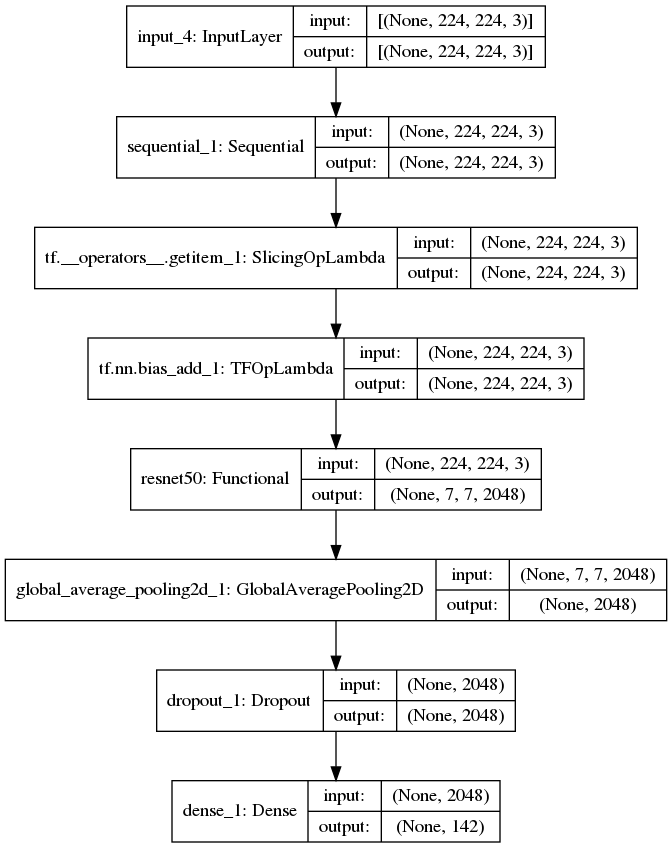

In [19]:
keras.utils.plot_model(model.model, show_shapes=True)

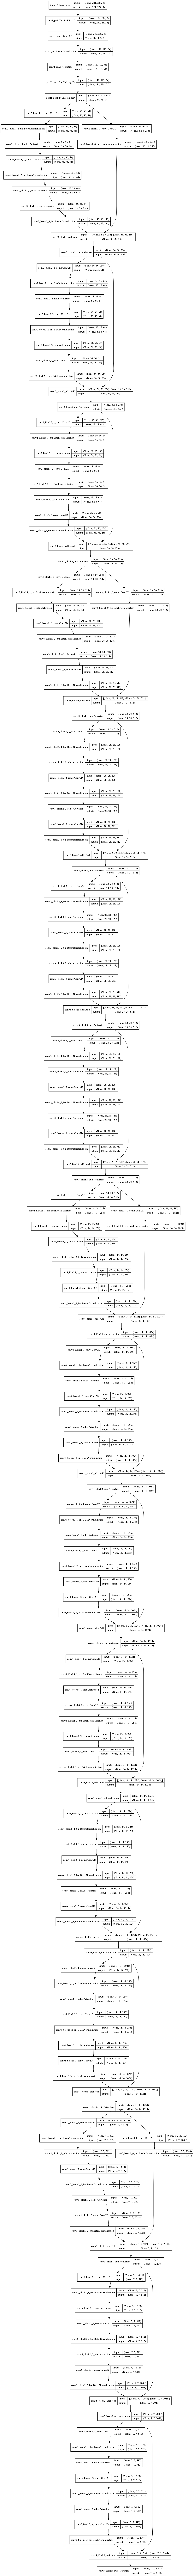

In [294]:
# functional part RES NET
keras.utils.plot_model(model.model.layers[4], show_shapes=True)

In [ ]:
from sklearn.metrics import brier_score_loss

<p>I will display &sum;</p>
<p>I will display &#8709;</p>
<p>I will display &#x2211;</p>


In [16]:
# select a part of dataset
# Y_prediction = milkC.predict(data['x_validation'])

# Y_prediction

# mm = np.unique(np.argmax(data['y_validation'], axis=1), return_counts=True)
# selected_ids = [a[0] for a in list(zip(*mm)) if a[1] > 50]
# data['mapping'][data['mapping'][1].isin(selected_ids)]

# selected_ids

# yval.argmax(axis=1)

# yval_idx = np.isin(data['y_validation'].argmax(axis=1),
#        selected_ids)
# yval = data['y_validation'][yval_idx]

# xval_idx= xval = np.isin(data['y_validation'].argmax(axis=1),
#        selected_ids)
# xval = data['x_validation'][xval_idx]

# POST TRAINing 

## LOAD MODEL

In [185]:
!ls /workspace/saved_models/brand_classifier/milk/resnet50

35_epoch_001_lr_finetune80  6_epoch_0001_lr_finetune80	logs


In [2]:
from tensorflow.keras.models import load_model
model_80= load_model('/workspace/saved_models/brand_classifier/milk/resnet50/6_epoch_0001_lr_finetune80')

## confusion matrix

In [4]:
import tqdm
from itertools  import islice
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [118]:
MODEL = model.model
# MODEL = model_80

In [119]:
Y_prediction = MODEL.predict(model.dataset['test'])
Y_pred_classes = np.argmax(Y_prediction,axis = 1) 
Y_true = model.dataset['test'].labels
# compute the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

b=cm.sum(axis=1).reshape(-1,1)
cm_p = np.divide(cm,
              b,
#               out=np.zeros_like(cm),
              where=b!=0
             )

df1 = pd.DataFrame(cm_p)
df2 = pd.DataFrame(cm)

cm_fr = ((df1*100).round(1).astype(str) + '%\n(' + df2.astype(str) + ')').values

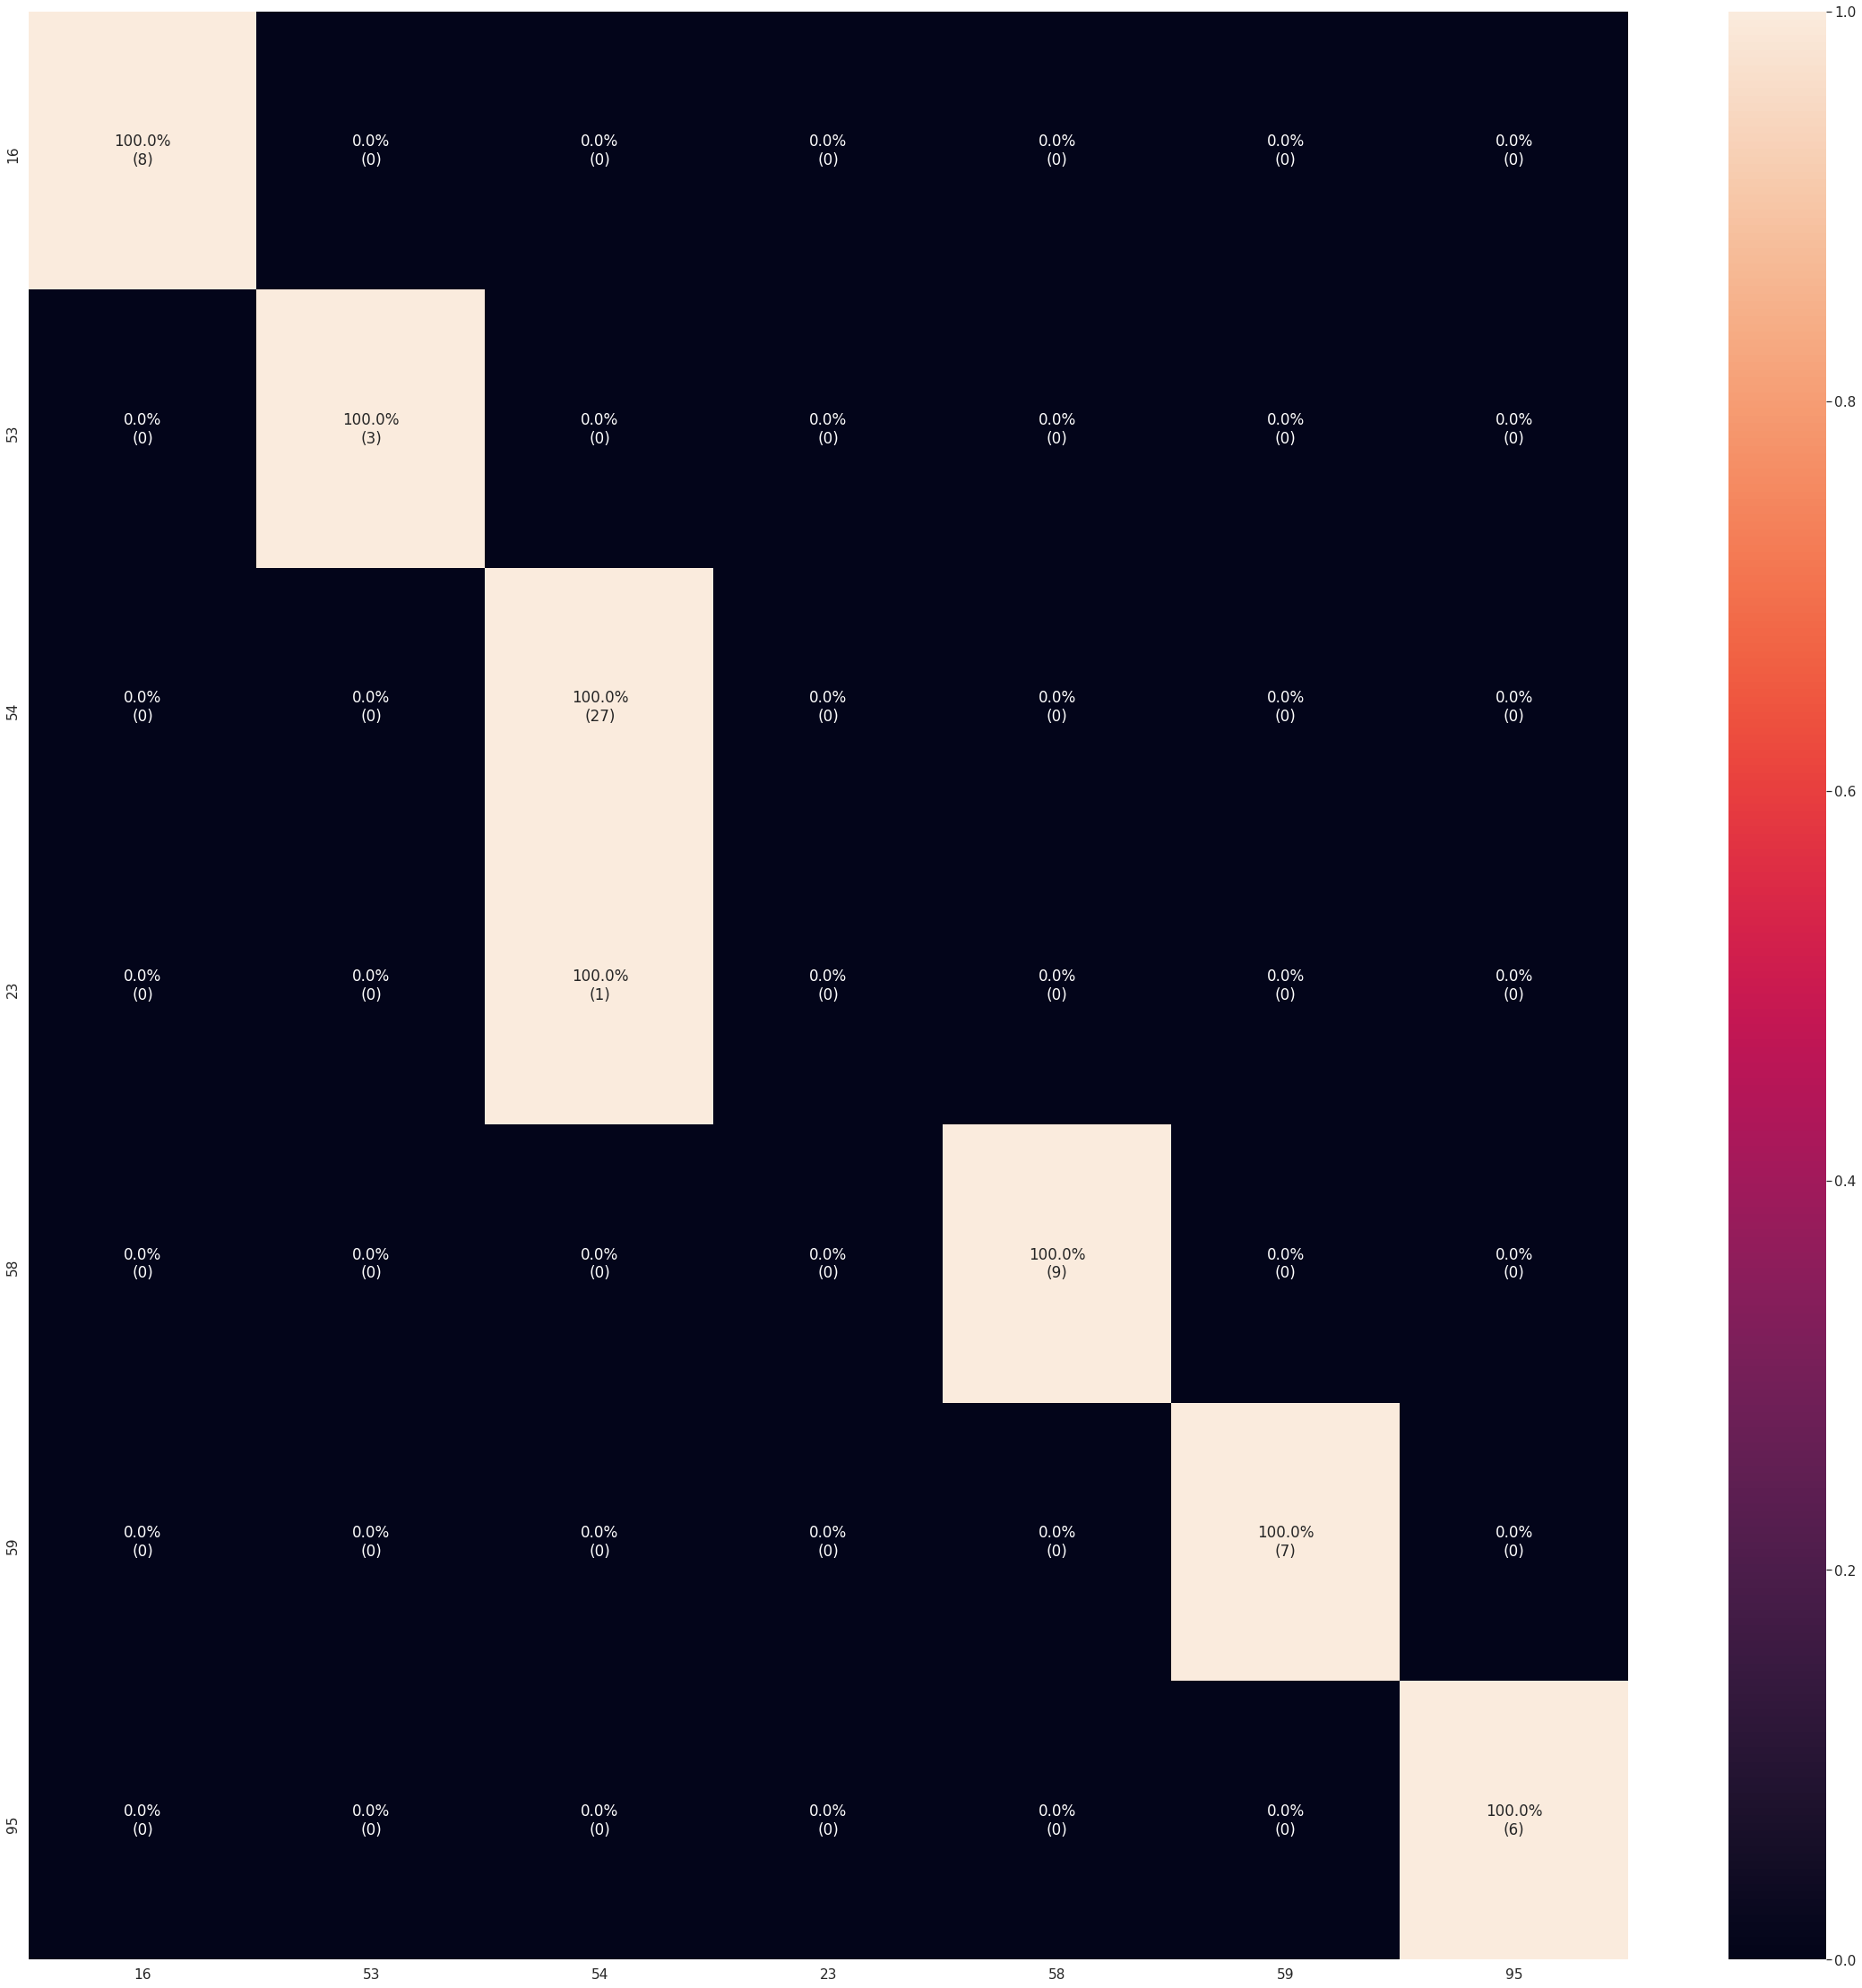

In [120]:
sns.set(font_scale=1.4)
plt.figure(figsize=(40,40))
fig = sns.heatmap(cm_p,
            annot=cm_fr,
                  fmt="",
            xticklabels = set(Y_true),
            yticklabels= set(Y_true),
           );

## dataframe vms code count

In [61]:
vms_to_code = model.dataset['mapping']
code_to_vms = {y:x for x,y in vms_to_code.items()}

In [36]:
dict_labels = model.dataset['mapping']
list(islice(dict_labels.items(),2))

[('106667', 0), ('106668', 1)]

In [37]:
M = pd.DataFrame.from_dict(dict_labels,
                       orient='index',
                       columns=['code'],).reset_index().set_index('code')
M.columns = ['vms']

A = pd.DataFrame(list(zip(*np.unique(Y_true,return_counts=True)))).set_index(0)
A.columns = ['count']
A.index.name = 'code'

a = A.join(M,rsuffix='_data_mapping')
a.columns = ['count', 'vms']
a.index.name = 'code'
a = a.sort_values('count', ascending=False)
a = a.reset_index()
a = a.astype({'vms' : int})
a.head(2)

code  count     vms
0    53     27  255690
1    58      9  270060

In [64]:
D = pd.DataFrame([Y_true,
             Y_pred_classes,
             Y_true == Y_pred_classes]).T
D.columns = ['True_label', 'Pred', 'Guess_right?']
D = D.assign(S = np.where(D['True_label']== D['Pred'],1,0))

D = D.assign(num_true = D.groupby('True_label').S.transform(lambda x:sum(x)), 
             num_all = D.groupby('True_label').S.transform(lambda x:x.count())
            )

D.loc[:,'percent_true'] = (D.num_true / D.num_all)*100

D = D.assign(percent_bins = pd.cut(D.percent_true,bins=[0,50,70,90,100],include_lowest=True,precision=3))



D = D.assign(
    vms_pred = D.Pred.map(code_to_vms)
)

D = D.assign(
    vms_true = D.Pred.map(code_to_vms)
)

D

True_label Pred Guess_right?  S  num_true  num_all  percent_true  \
0          16   16         True  1         8        8         100.0   
1          16   16         True  1         8        8         100.0   
2          16   16         True  1         8        8         100.0   
3          16   16         True  1         8        8         100.0   
4          16   16         True  1         8        8         100.0   
..        ...  ...          ... ..       ...      ...           ...   
56         95   95         True  1         6        6         100.0   
57         95   95         True  1         6        6         100.0   
58         95   95         True  1         6        6         100.0   
59         95   95         True  1         6        6         100.0   
60         95   95         True  1         6        6         100.0   

     percent_bins vms_pred vms_true  
0   (90.0, 100.0]   172276   172276  
1   (90.0, 100.0]   172276   172276  
2   (90.0, 100.0]   172276   172276  
3   (90.0, 100.0]   172276   172276  
4   (90.0, 100.0]   172276   172276  
..            ...      ...      ...  
56  (90.0, 100.0]   332974   332974  
57  (90.0, 100.0]   332974   332974  
58  (90.0, 100.0]   332974   332974  
59  (90.0, 100.0]   332974   332974  
60  (90.0, 100.0]   332974   332974  

[61 rows x 10 columns]

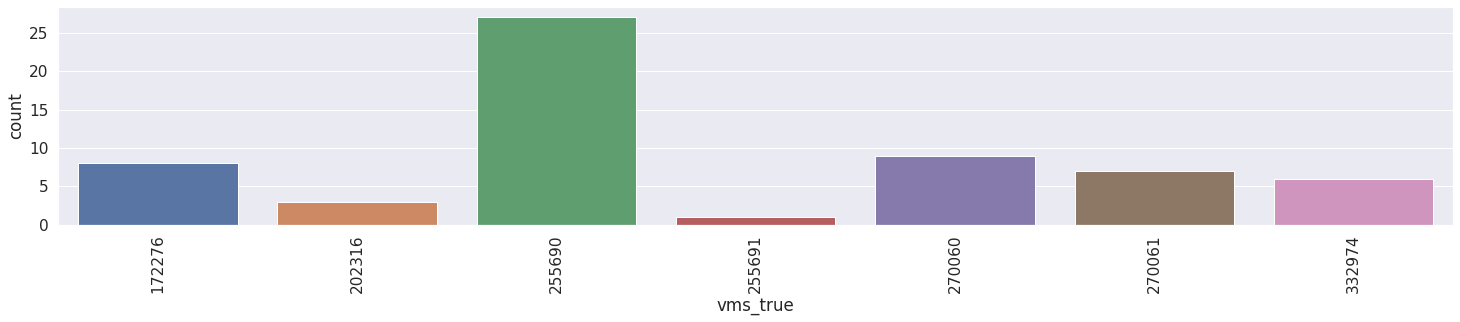

In [65]:
import seaborn as sns
plt.figure(figsize=(25,4))
ax = sns.countplot(x='vms_true', data=D);
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

## predictions bins 

<AxesSubplot:xlabel='percent_bins'>

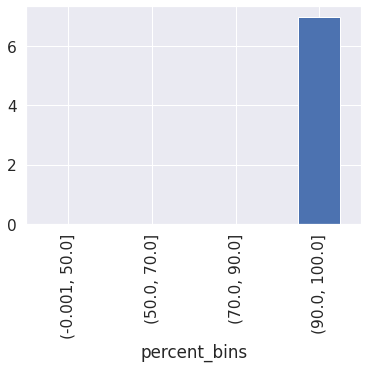

In [44]:
D.drop_duplicates(subset=['True_label', 'percent_bins']).groupby('percent_bins').size().plot(kind='bar')

## WRONG GUESSES

In [41]:
X = D[D.S==0]

XX = X.groupby(['True_label','Pred'])['Guess_right?'].count().to_frame().reset_index()
XX = XX.assign(num_all = XX.groupby('True_label')['Guess_right?'].transform(lambda x:sum(x)), 
            )
XX = XX.assign(percent_repeated = (XX['Guess_right?'] / XX['num_all'])*100 )
XX.head(2)

Empty DataFrame
Columns: [True_label, Pred, Guess_right?, num_all, percent_repeated]
Index: []

## less accurate <80

In [47]:
less_accurate = D[D.percent_true < 80]
less_accurate = less_accurate.assign(
    vms_true = less_accurate.True_label.map({int(aa.code) :aa.vms for aa in a.itertuples()}))

In [48]:
less_accurate = less_accurate.assign(
    vms_pred = less_accurate.Pred.map({int(aa.code) :aa.vms for aa in a.itertuples()}))
less_accurate = less_accurate.astype({'True_label' : int,
                     'Pred':int})


nval_vms = less_accurate['vms_true'].max() + 1
nval = less_accurate['True_label'].max() + 1

less_accurate.loc[-1] = [nval,nval,True,1, 1, 1,100,D.percent_bins.max(),nval_vms,nval_vms]
less_accurate['Pred_m'] = \
    np.where(less_accurate.Pred.isin(less_accurate["True_label"].values),less_accurate.Pred, nval )
less_accurate['Pred_m_vms'] = \
    np.where(less_accurate.vms_pred.isin(less_accurate["vms_true"].values),less_accurate.vms_pred, nval_vms )
nval

nan

In [142]:
# [item[1] for item in zip(a['code'],a['vms']) if item[0] in lables]

In [50]:
s50s = less_accurate[np.isclose(less_accurate['percent_true'], [50], rtol=0.5)]

W = s50s[s50s.True_label.isin((s50s.groupby('True_label').Pred.nunique() == 2).index)]
W = W[W['Guess_right?'] == False]
W = W.drop_duplicates()
W

Empty DataFrame
Columns: [True_label, Pred, Guess_right?, S, num_true, num_all, percent_true, percent_bins, vms_true, vms_pred, Pred_m, Pred_m_vms]
Index: []

# PLOT WRONG PREDS

In [206]:
import PIL

In [70]:
import random

In [71]:
d0 = D[['True_label', 'Pred', 'vms_true', 'vms_pred']].values

In [86]:
imgs = get_image_by_code(22, model)

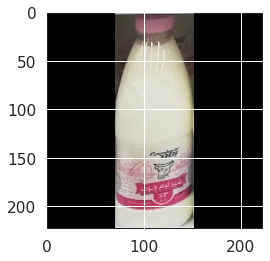

In [89]:
plt.imshow(cv2.cvtColor(imgs[1] ,cv2.COLOR_BGR2RGB ))

In [90]:
def get_image_by_code(code, model):
    images_list = []
    M = {y:x for x,y in model.dataset['mapping'].items()}
    VMS = M.get(code)
    path = f'/workspace/data/brand/milk/train-val/{VMS}/'
    img_names = random.choices(os.listdir(path),
               k=2)
    
    for im in img_names:
        img = cv2.imread(path + im)
        img = cv2.cvtColor(img ,cv2.COLOR_BGR2RGB )
        images_list.append(img)
    return images_list

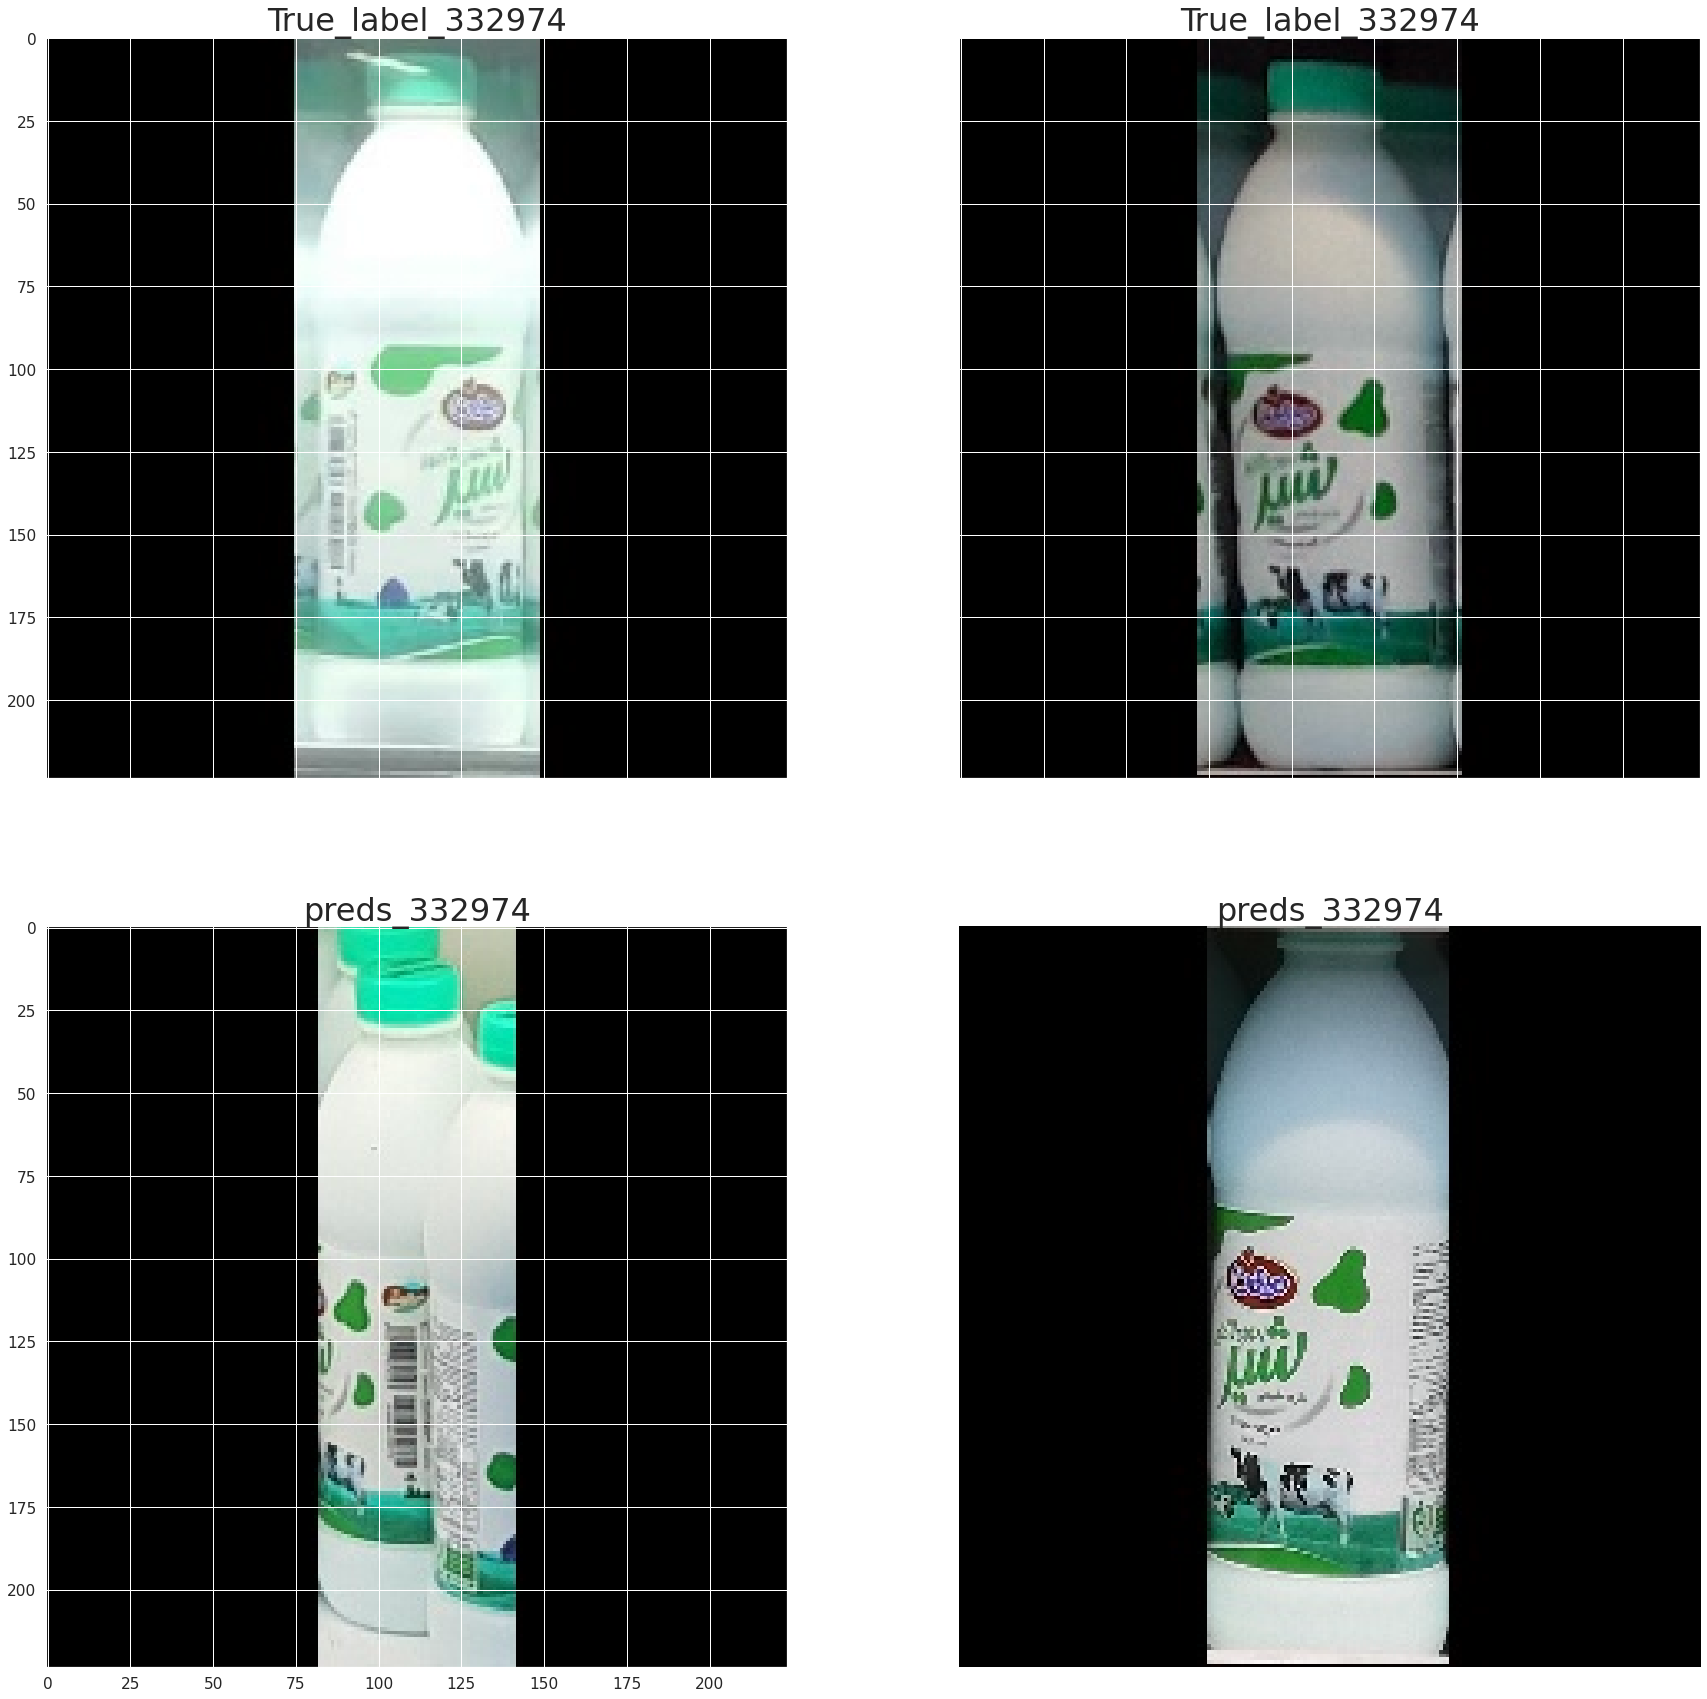

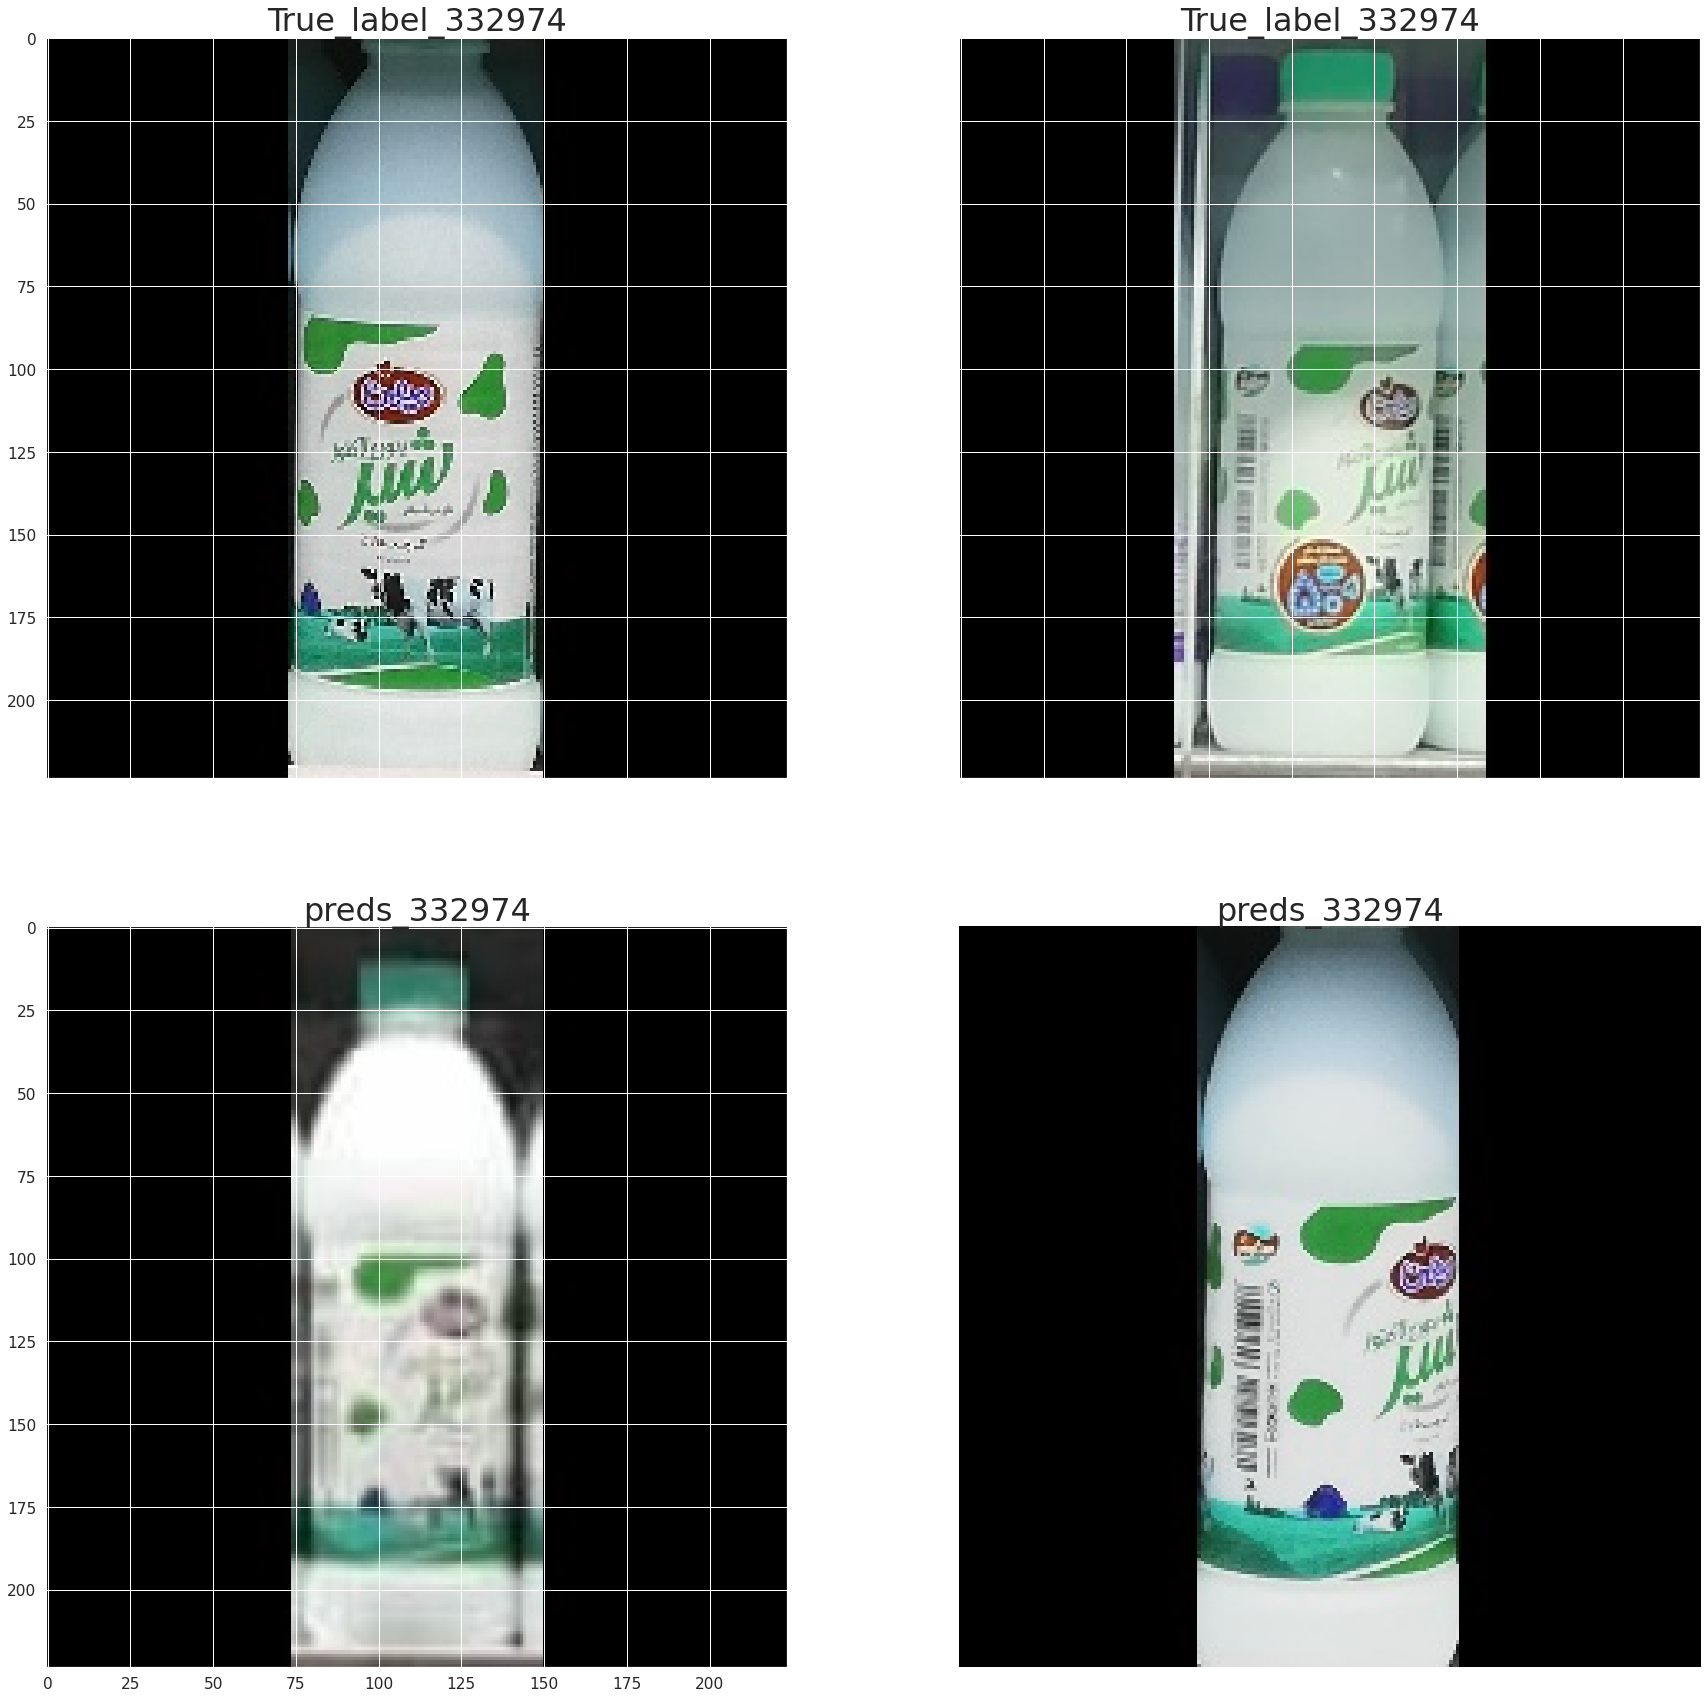

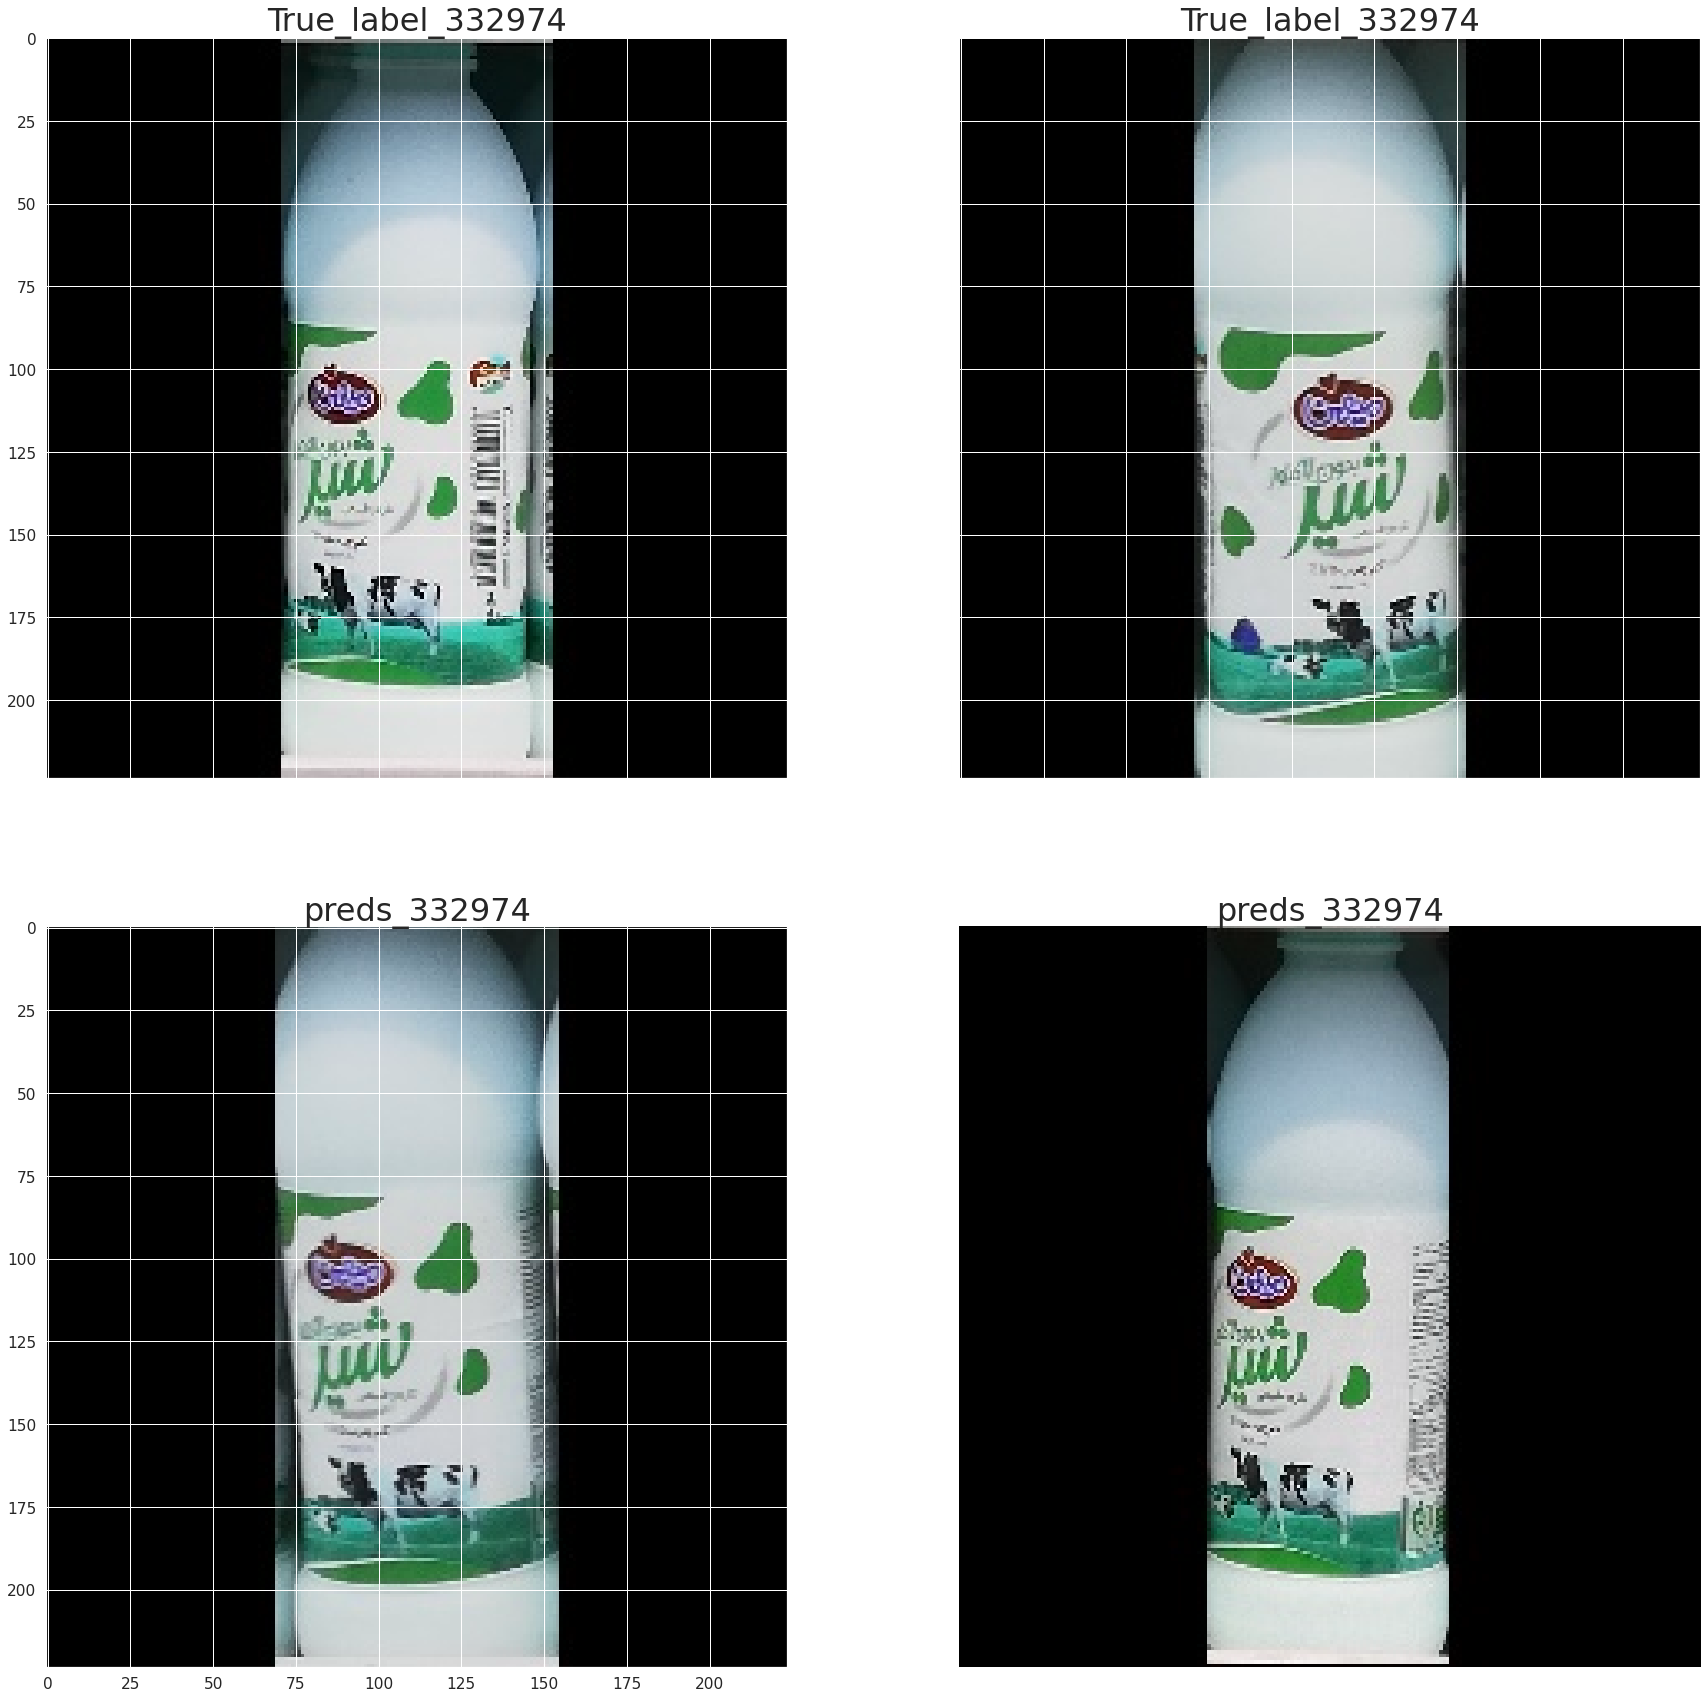

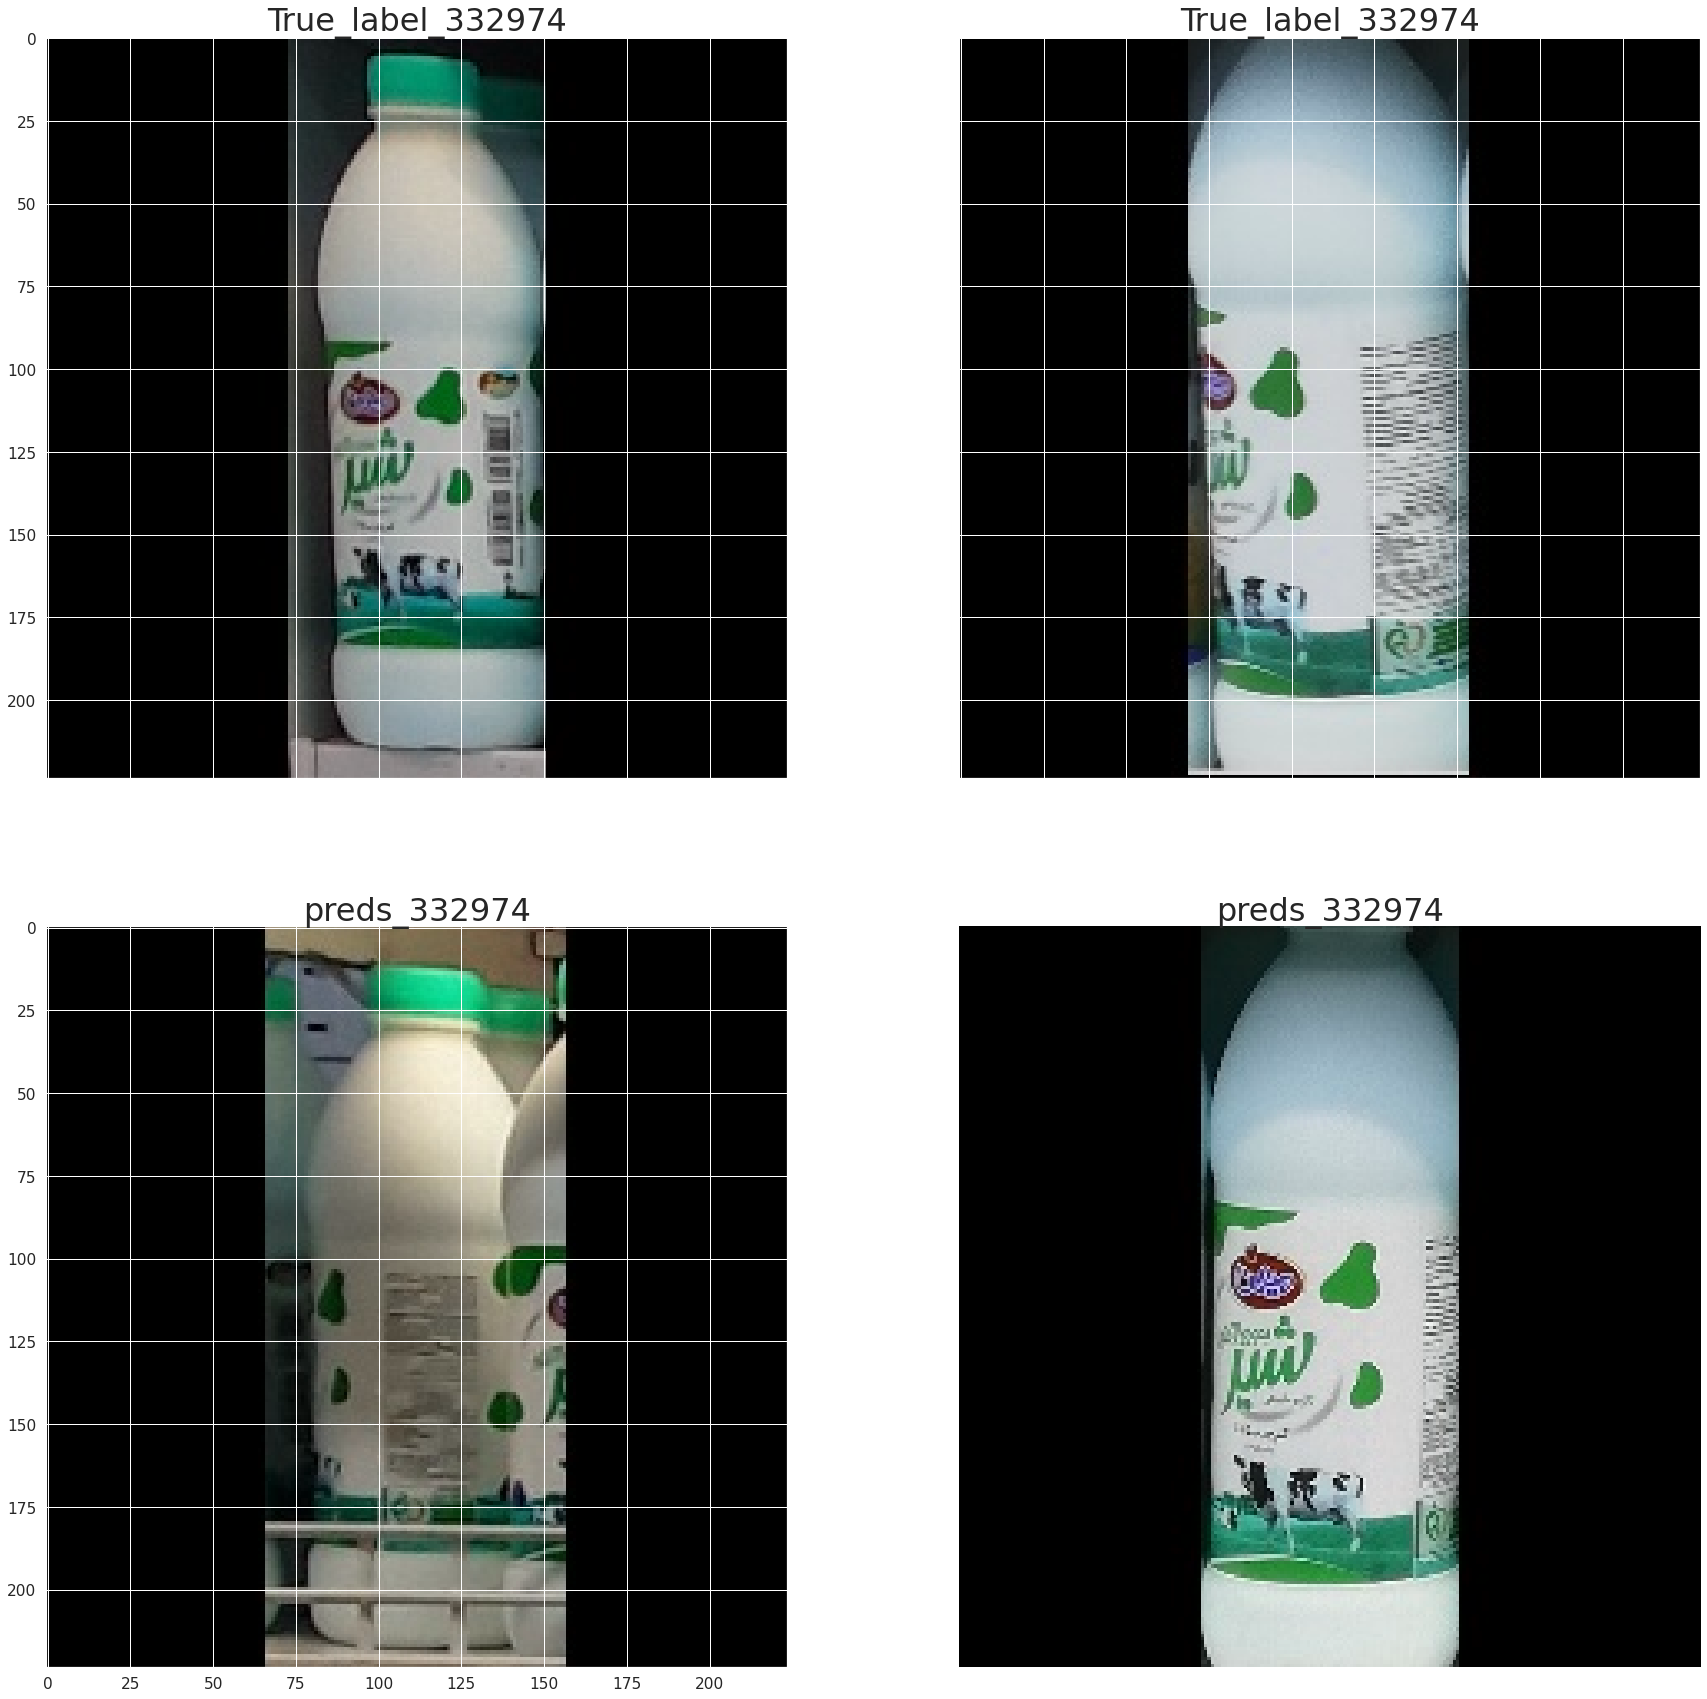

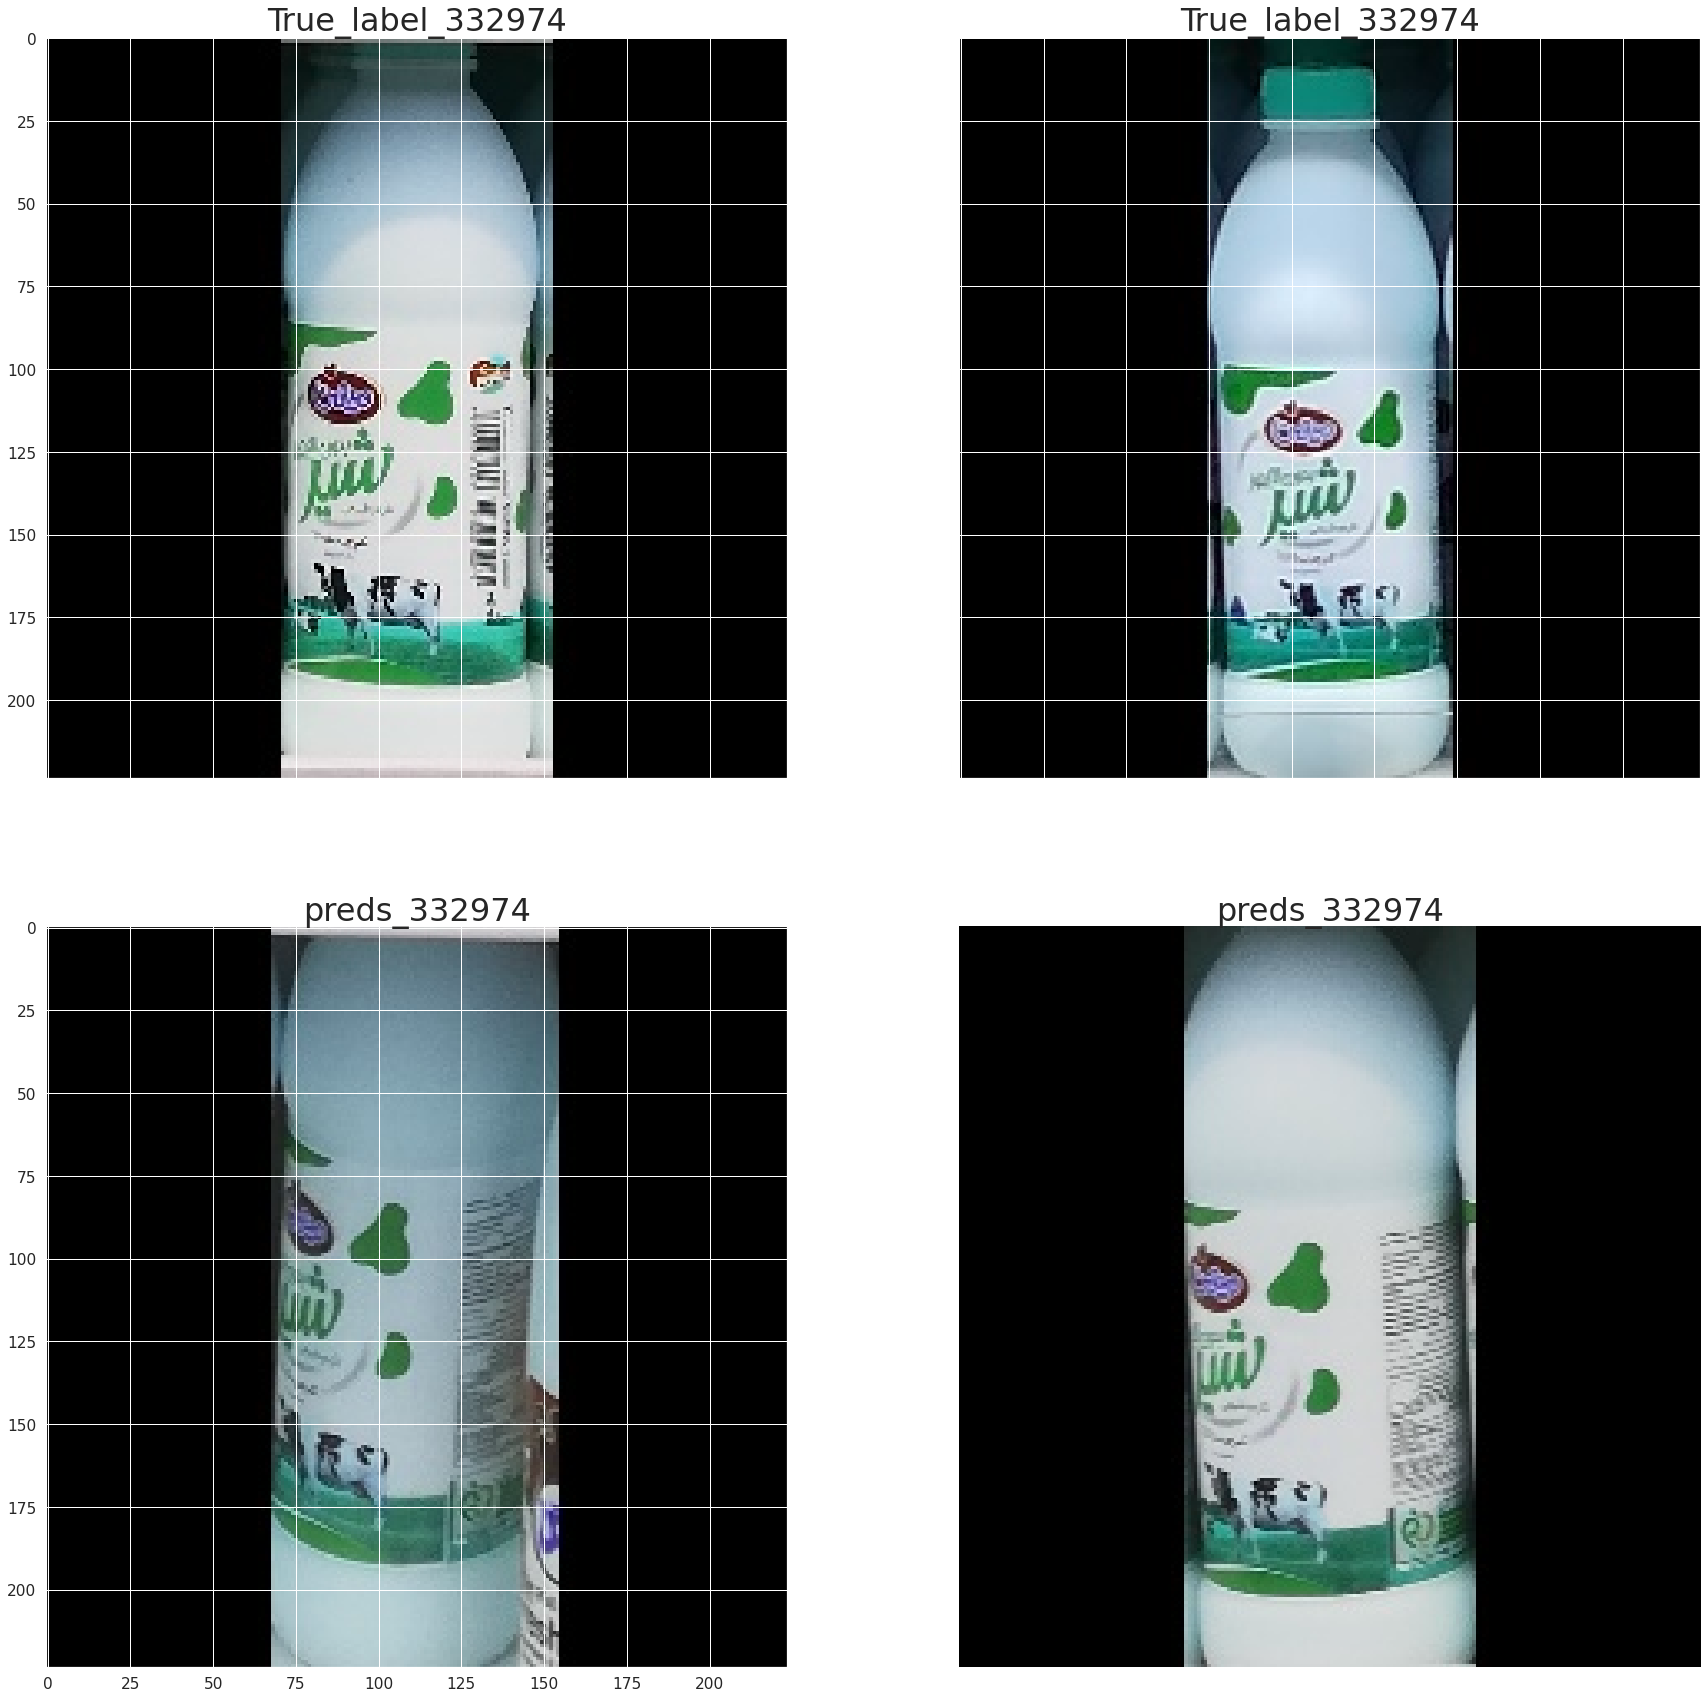

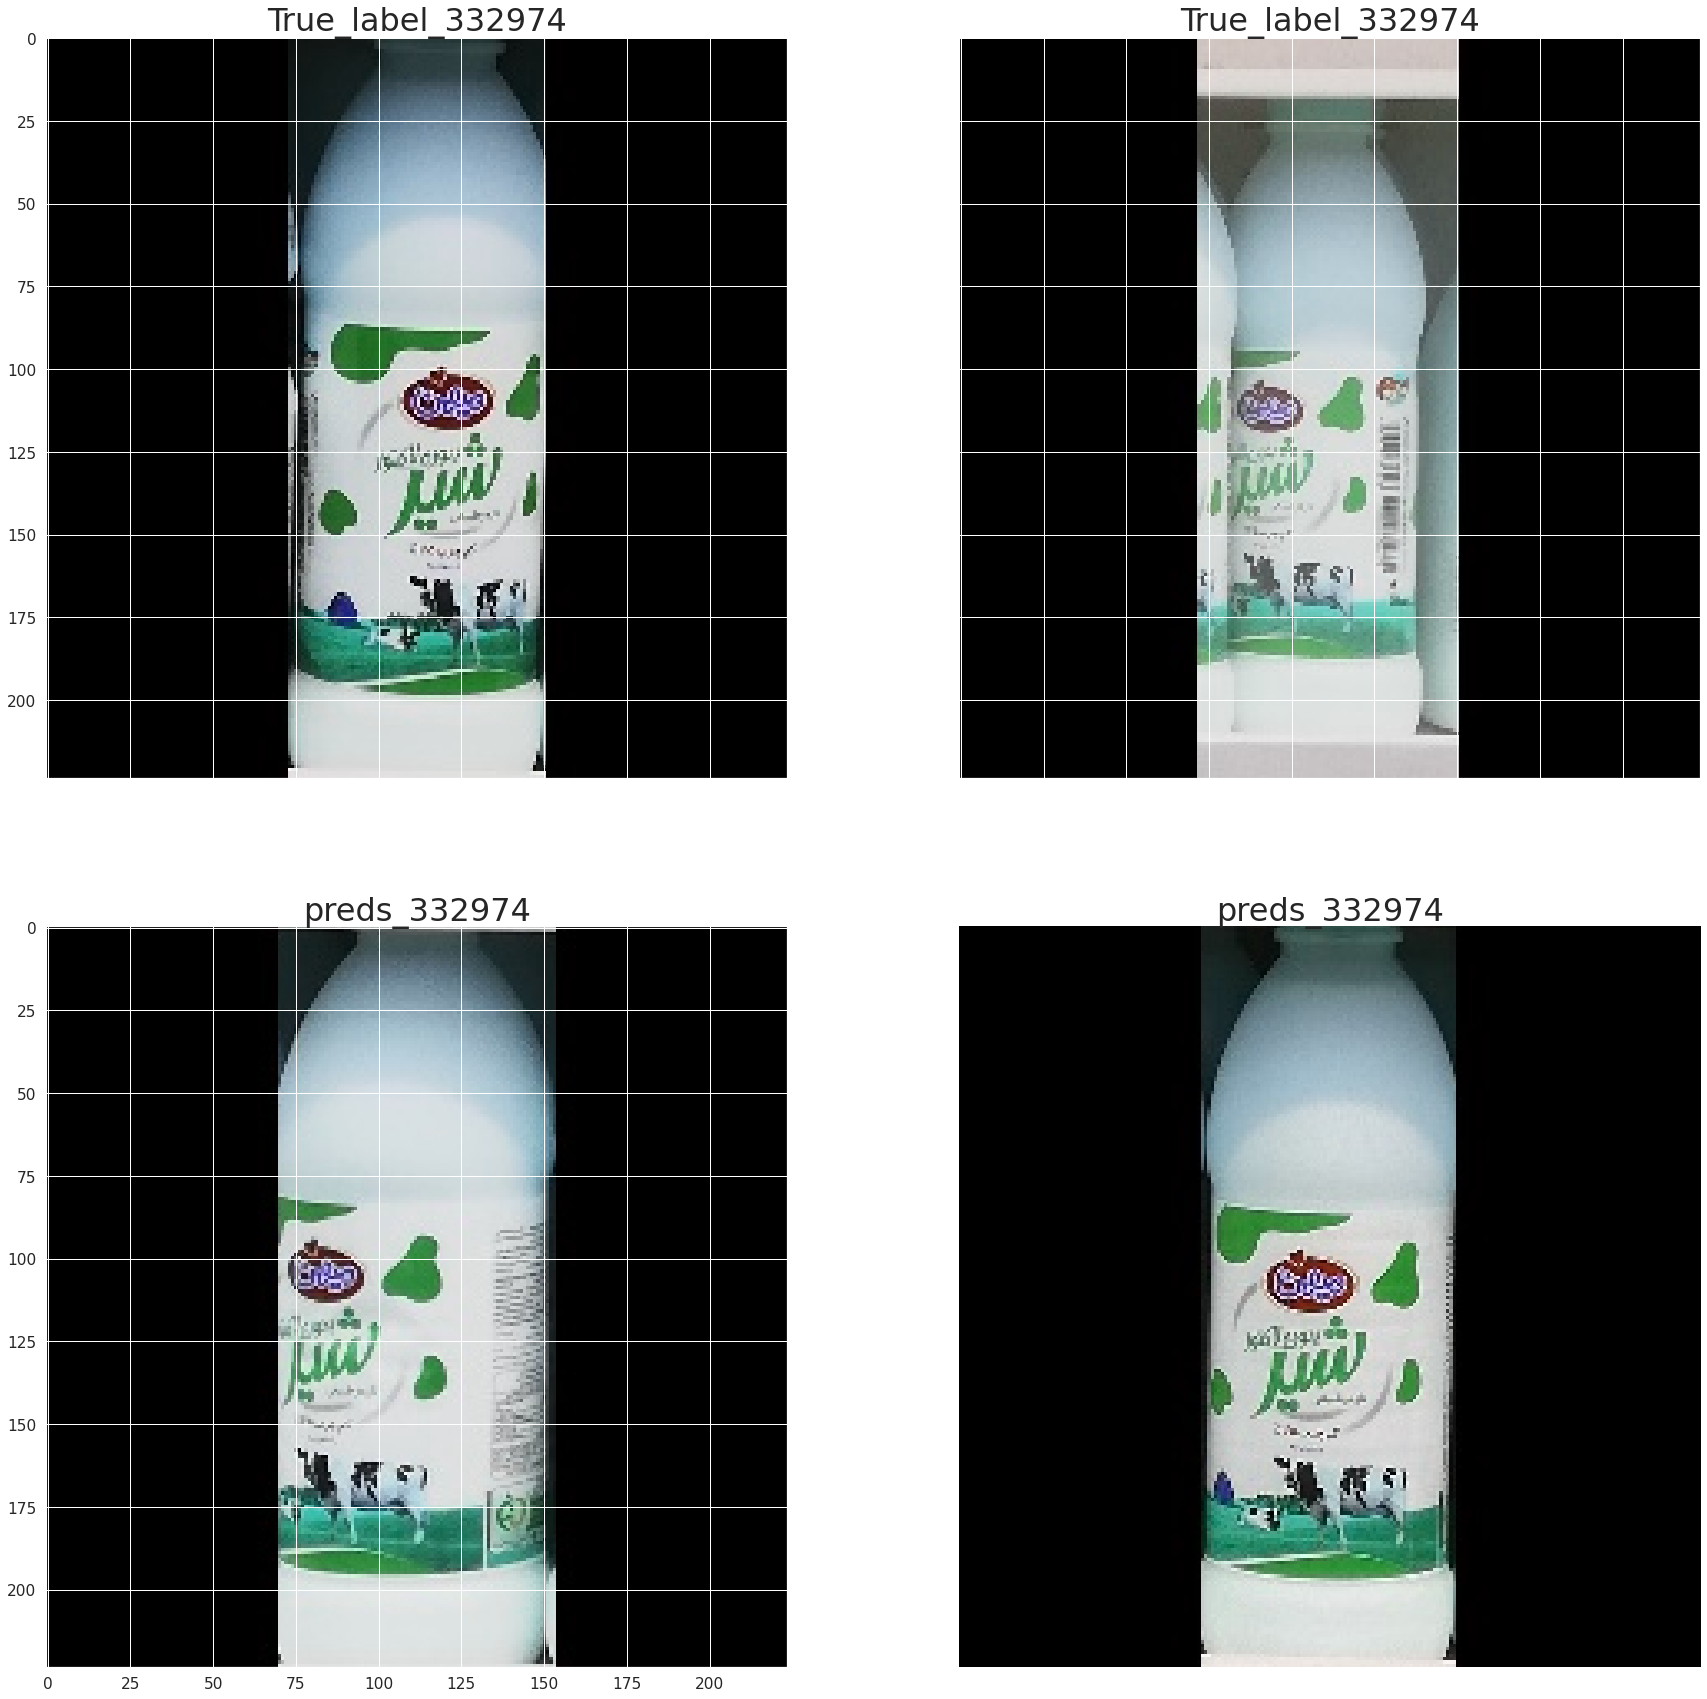

In [72]:
for row in d0:
    img1, img2 = get_image_by_code(row[0], model)
    img3, img4 = get_image_by_code(row[1], model)
    
    f, ((ax1,ax2), (ax3,ax4))= plt.subplots(2,2, sharex=True, sharey=True, figsize=(30,30))
    
    ax1.imshow(img1,)
    ax1.set_title(f'True_label_{row[2]}', {'fontsize':32})
    ax2.imshow(img2,)
    ax2.set_title(f'True_label_{row[2]}', {'fontsize':32})
    ax3.imshow(img3,)
    ax3.set_title(f'preds_{row[3]}', {'fontsize':32})
    ax4.imshow(img4,)
    ax4.set_title(f'preds_{row[3]}', {'fontsize':32})
    plt.axis('off')
    plt.show()

In [377]:
pred_df = pd.DataFrame([Y_true,Y_pred_classes]).T
pred_df.columns = ['Y_true', 'Y_pred_classes']

wrong = pred_df[pred_df['Y_true'] != pred_df['Y_pred_classes']]
true = pred_df[pred_df['Y_true'] == pred_df['Y_pred_classes']]

In [258]:
# mm = np.unique(np.argmax(model.dataset['y_validation'], axis=1), return_counts=True)
# [a[0] for a in list(zip(*mm)) if a[1] > 50]

In [259]:
# mapping[mapping[1].isin([a[0] for a in list(zip(*mm)) if a[1] > 50])]

<font color=red>  30 epoch </font> <font color = green>fine_tune_at=80 (175 total) </font><br>
103/103 [==============================] - 5s 51ms/step - loss: 0.2283 - accuracy: 0.9343 - auc_2: 0.9955

<font color=red> 10 epoch more augmentaion <b>(cutout)</b>  </font> <font color = green>fine_tune_at=80 (175 total) </font><br>
103/103 [==============================] - 5s 50ms/step - loss: 0.2612 - accuracy: 0.9173 - auc: 0.9960


<font color=red> 20 epoch added more augmentaion (cutout)  </font> <font color = green>fine_tune_at=<b>100</b> (175 total) </font><br>
103/103 [==============================] - 5s 51ms/step - loss: 0.2382 - accuracy: 0.9343 - auc_1: 0.9938


<font color=red> <b>30</b> epoch more augmentaion <b>(cutout)</b>  </font> <font color = green>fine_tune_at=80 (175 total) </font><br>
103/103 [==============================] - 5s 50ms/step - loss: 0.2416 - accuracy: 0.9286 - auc_2: 0.9942

<font color=red> <b>100</b> epoch more augmentaion (cutout)  </font> <font color = green>fine_tune_at=80 (175 total) </font><br>
103/103 [==============================] - 5s 50ms/step - loss: 0.2037 - accuracy: 0.9474 - auc_3: 0.9949

## RUN inference 

In [83]:
# !mv /root/scp-files/hph-255690-a.jpg /workspace/notebooks/test_images/

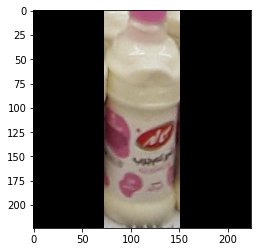

In [152]:
plt.imshow(keras.preprocessing.image.img_to_array(img[0,...]).astype(np.uint8), cmap='gray')

In [181]:
image_size = (224,224,3)
img = keras.preprocessing.image.load_img(
    "test_images/hph-255690-a.jpg", target_size=image_size, color_mode='rgb',
)

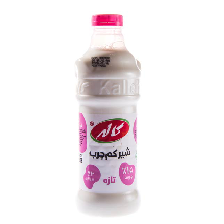

In [182]:
img

In [156]:
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis
# predictions = model.model.predict(img_array)
predictions = model.model.predict(img_array)

# mapping[mapping[1]==predictions.argmax()]
# score = predictions[0]
# print(
#     "This image is %.2f percent cat and %.2f percent dog."
#     % (100 * (1 - score), 100 * score)
# )

In [159]:
M.loc[np.argmax(predictions)]

vms    255690
Name: 53, dtype: object

<AxesSubplot:title={'center':'Log false'}>

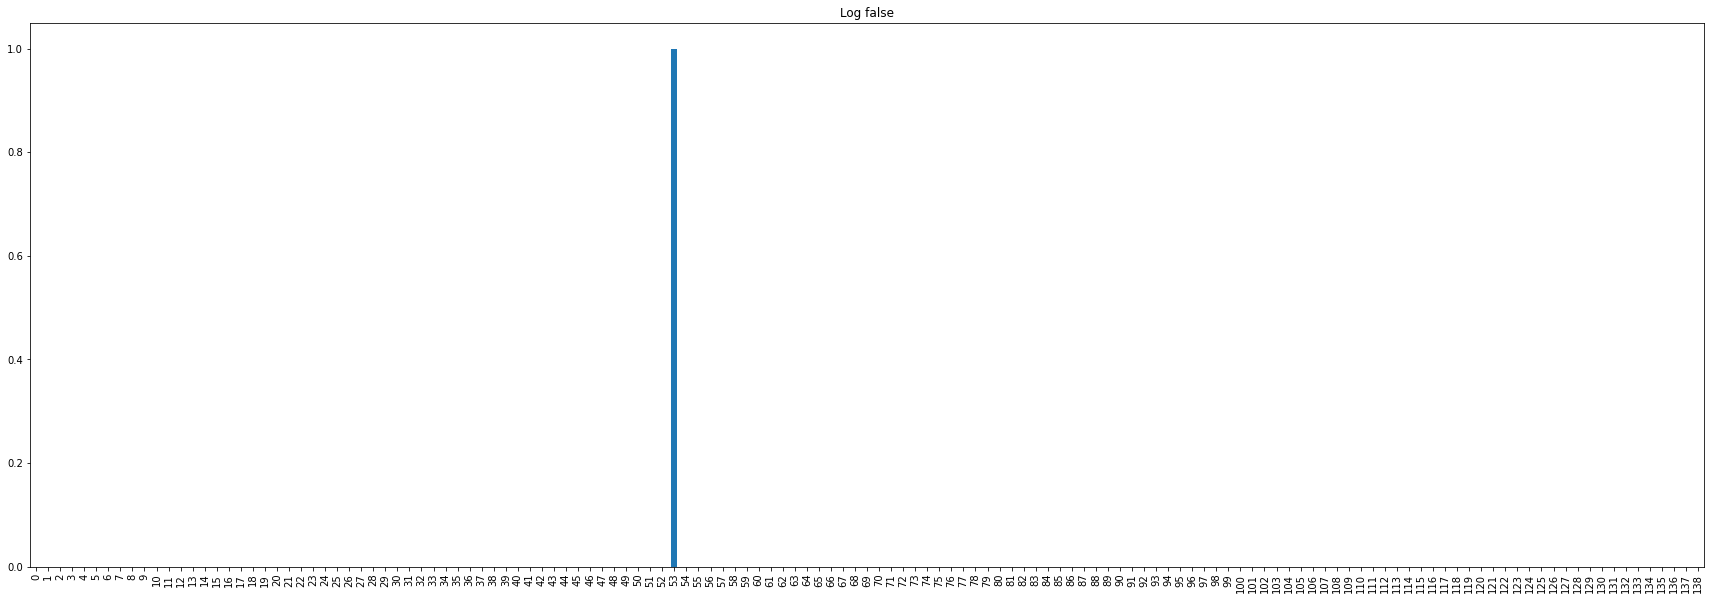

In [160]:
pd.Series(*predictions).plot(kind='bar',
                             logy=False,
                             figsize=(30,10),
                            title='Log false',
#                             stack=True
                            )

<AxesSubplot:title={'center':'Log true'}>

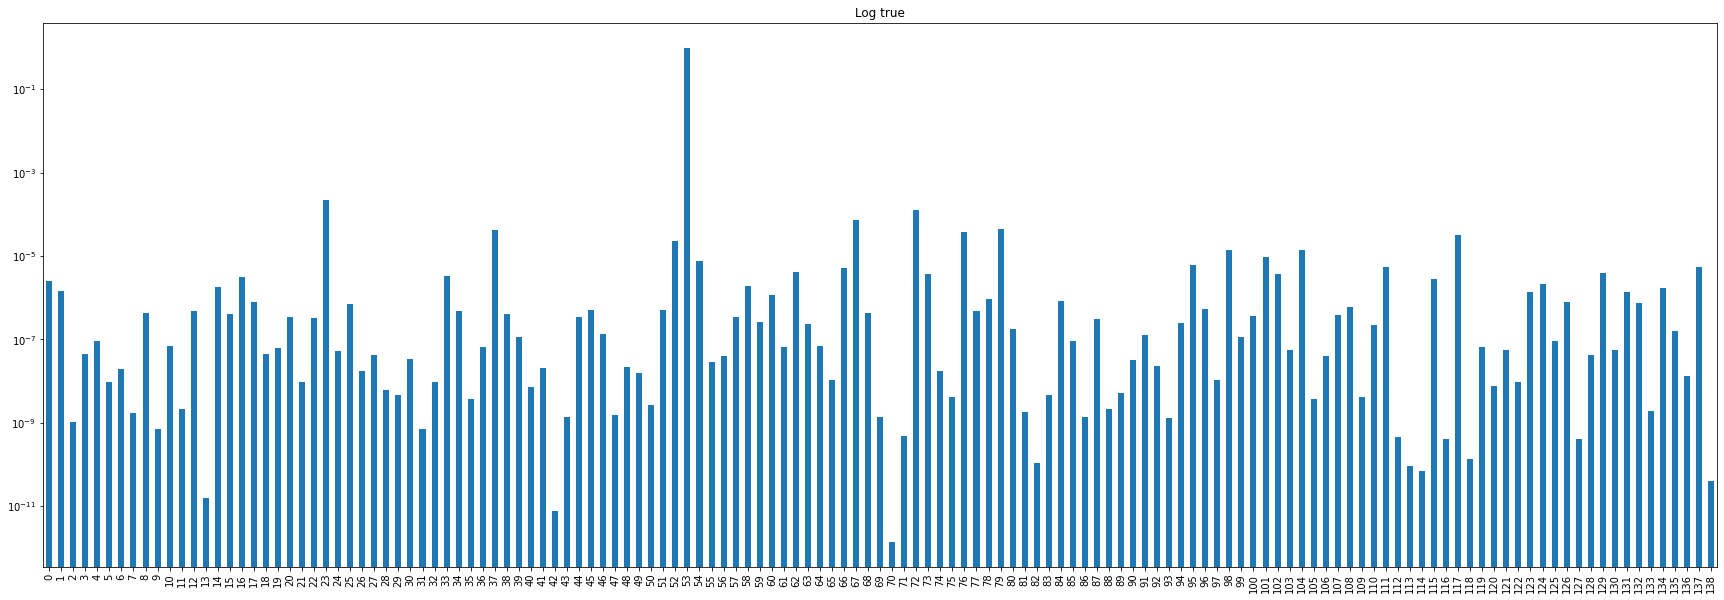

In [161]:
pd.Series(*predictions).plot(kind='bar',
                             logy=True,
                             figsize=(30,10),
                            title='Log true')

## layers (filters) Visualize 

In [75]:
for i in range(len(model.model.layers[4].layers)):
	layer = model.model.layers[4].layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 conv1_bn (None, 112, 112, 64)
4 conv1_relu (None, 112, 112, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_conv (None, 56, 56, 64)
11 conv2_block1_2_bn (None, 56, 56, 64)
12 conv2_block1_2_relu (None, 56, 56, 64)
13 conv2_block1_0_conv (None, 56, 56, 256)
14 conv2_block1_3_conv (None, 56, 56, 256)
15 conv2_block1_0_bn (None, 56, 56, 256)
16 conv2_block1_3_bn (None, 56, 56, 256)
17 conv2_block1_add (None, 56, 56, 256)
18 conv2_block1_out (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)
20 conv2_block2_1_bn (None, 56, 56, 64)
21 conv2_block2_1_relu (None, 56, 56, 64)
22 conv2_block2_2_conv (None, 56, 56, 64)
23 conv2_block2_2_bn (None, 56, 56, 64)
24 conv2_block2_2_relu (None, 56, 56, 64)
25 conv2_block2_3_conv (None, 56, 56, 256)
26 conv2_block2_3_bn (None, 56, 56, 256)
27 conv2_block2_add (None, 56, 56, 256)
28 

In [76]:
from itertools import islice

dict_con_layers = dict()
for i,l in enumerate(model.model.layers[4].layers):
#     print(i,'\n---',l, '\n', l.output.shape)
    if 'conv' not in l.name:
        continue
    dict_con_layers[l.name] = l


[dict_con_layers[x] for x in list(islice(dict_con_layers,7))]

In [166]:
### get layers

lll = []
for i, layer in enumerate(model.model.layers[3].layers):
    w = layer.get_weights()
    if w:
        if w[0].shape[0] > 1 and len(w[0].shape)>1 :
            lll.append([i,layer])
            
        

In [167]:
lll

[[2, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56abeb9af0>],
 [10, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a8429c40>],
 [22, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a8437130>],
 [32, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a83e5d00>],
 [42, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56ab5af310>],
 [54, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a83a44f0>],
 [64, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a83d1700>],
 [74, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a83758b0>],
 [84, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a8393340>],
 [96, <tensorflow.python.keras.layers.convolutional.Conv2D at 0x7f56a8332100>],
 [106,
 [116,
 [126,
 [136,
 [146,
 [158,
 [168,

In [168]:
L = model.model.layers[3].layers[2]
L.name

'conv1_conv'

In [169]:
L.trainable

False

In [170]:
len(L.get_weights()[0].shape)

4

In [171]:
L.input.shape

TensorShape([None, 230, 230, 3])

In [172]:
L.output.shape

TensorShape([None, 112, 112, 64])

In [173]:
filters, biases = L.get_weights()

In [174]:
filters.shape

(7, 7, 3, 64)

In [175]:
filters.shape

(7, 7, 3, 64)

In [176]:
plt.figure(figsize = (4,4))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # se

<Figure size 288x288 with 0 Axes>

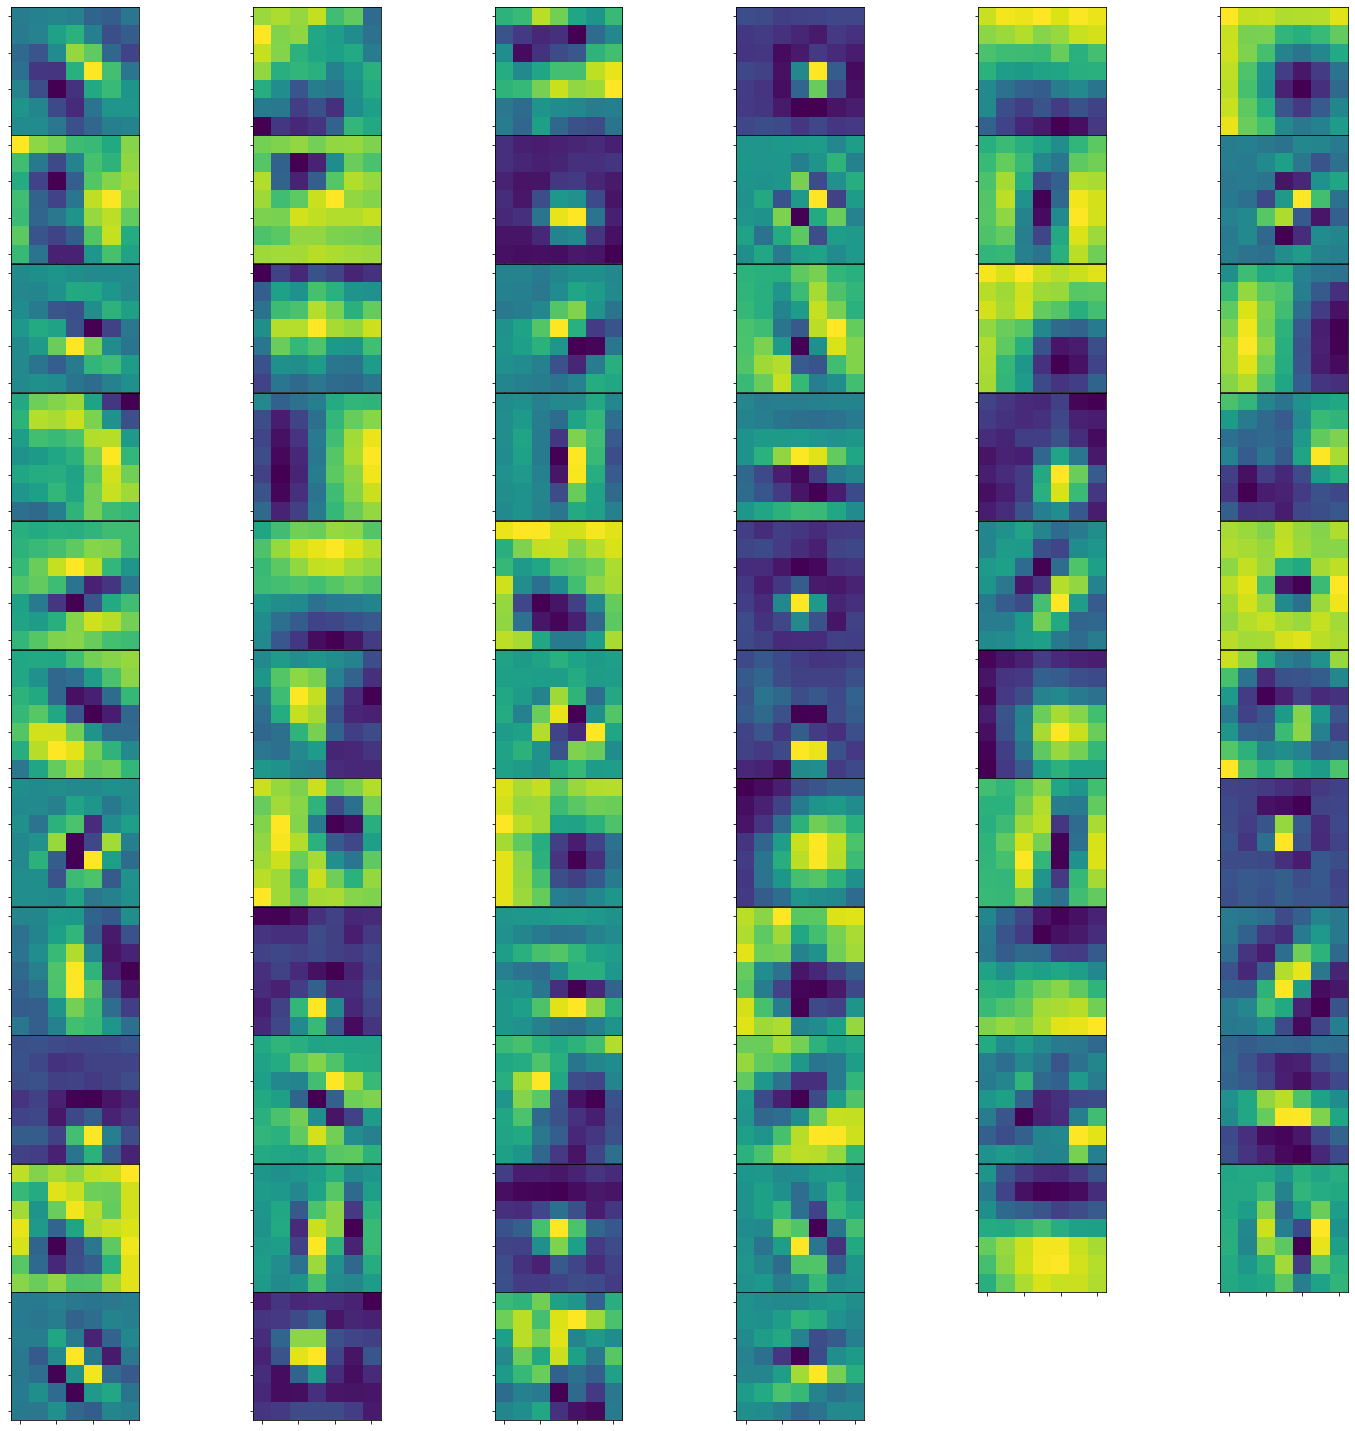

In [177]:
nrows = (filters.shape[-1])//6 + 1
plt.figure(figsize = (26,26))
gs1 = gridspec.GridSpec(nrows, 6)
gs1.update(wspace=0.0025, hspace=0.005) # set the spacing between axes. 

for i, box in enumerate(filters[:,:,:,i] for i in range(filters.shape[-1])):
   # i = i + 1 # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    ax1.imshow(box[:,:,1],
#                aspect=0.8
         )
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

# plt.tight_layout()
plt.show()

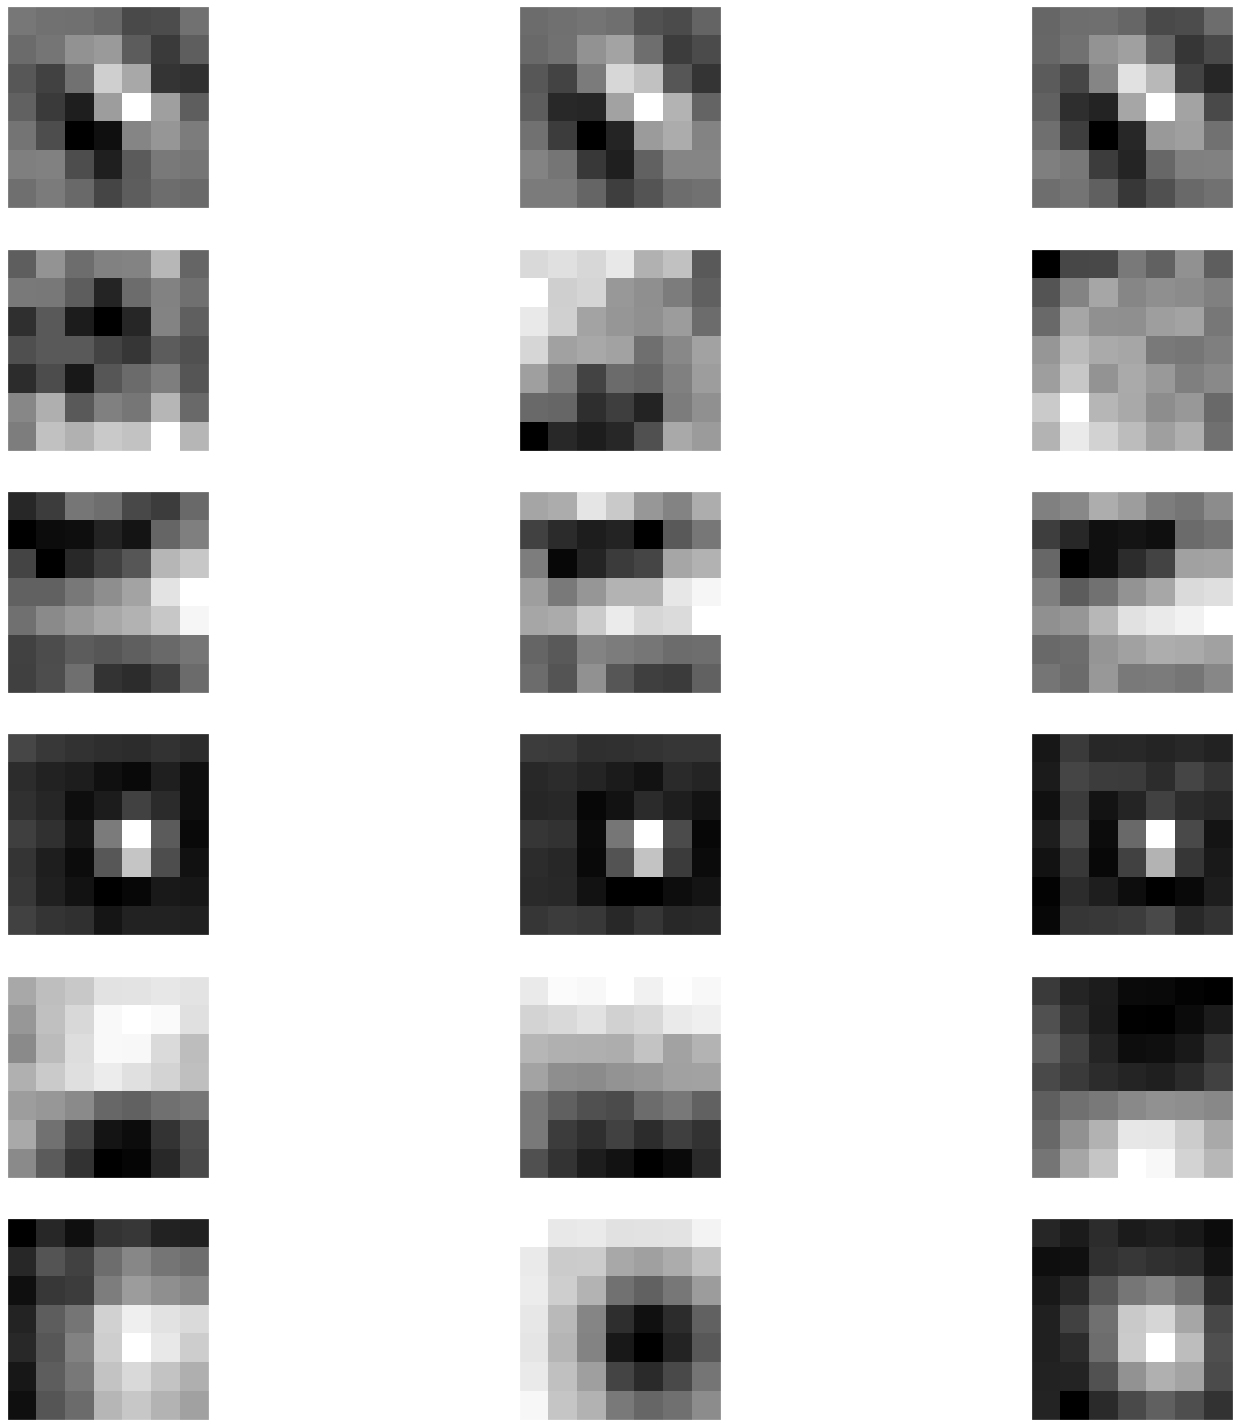

In [270]:
# normalize filter values to 0-1 so we can visualize them
plt.figure(figsize = (26,26))
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j],
                   cmap='gray'
                  )
		ix += 1
# show the figure
plt.show()

In [388]:
from keract import get_activations

In [180]:
plt.imshow(img_array[0].astype(np.uint8))

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'astype'

In [397]:
# get_activations(milkC.model,img_array )

In [113]:
# inputs = tf.keras.Input(shape=(224, 224, 3))
# model = Model(inputs=inputs, outputs=L.output)

In [ ]:
# from vis.visualization import visualize_cam, overlay
# from vis.utils import utils
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.cm as cm


In [ ]:
# image_size = (224,224,3)
# img = keras.preprocessing.image.load_img(
#     "test_images/hph-255690-a.jpg", target_size=image_size
# )

# img_array = keras.preprocessing.image.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0)  # Create batch axis


# activations = milkC.model.predict(img_array)
 

In [ ]:
# def display_activation(activations, col_size, row_size, act_index): 
#     activation = activations[act_index]
#     activation_index=0
#     fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
#     for row in range(0,row_size):
#         for col in range(0,col_size):
#             ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
#             activation_index += 1
        

In [ ]:
# display_activation(activations, 8, 8, 1)

# PRE PROCESS

## augmentation

In [114]:
img = data['x_train'][0]
img = np.expand_dims(img,0)

In [ ]:
# from numpy import expand_dims
# from keras.preprocessing.image import load_img
# from keras.preprocessing.image import img_to_array
# from keras.preprocessing.image import ImageDataGenerator
# from matplotlib import pyplot
# # load the image
# plt.figure(figsize=(10, 10))
# # convert to numpy array
# # data = img_to_array(img[0])
# # expand dimension to one sample
# samples = expand_dims(img[0], 0)
# # create image data augmentation generator
# datagen = ImageDataGenerator(rotation_range=90)
# # prepare iterator
# it = datagen.flow(samples, batch_size=1)
# # generate samples and plot
# for i in range(9):
# 	# define subplot
# 	pyplot.subplot(330 + 1 + i)
# 	# generate batch of images
# 	batch = it.next()
# 	# convert to unsigned integers for viewing
# 	image = batch[0].astype('uint8')
# 	# plot raw pixel data
# 	pyplot.imshow(image)
# # show the figure
# pyplot.show()

In [115]:
data_augmentation = keras.Sequential(
    [
          tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomFlip('vertical'),
          tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
          tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
          tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2),
        RandomCutout((100,100)),
#           tf.keras.layers.experimental.preprocessing.RandomCrop(224,224,),
#         tf.keras.layers.experimental.preprocessing.Rescaling(),
    ]
)

1


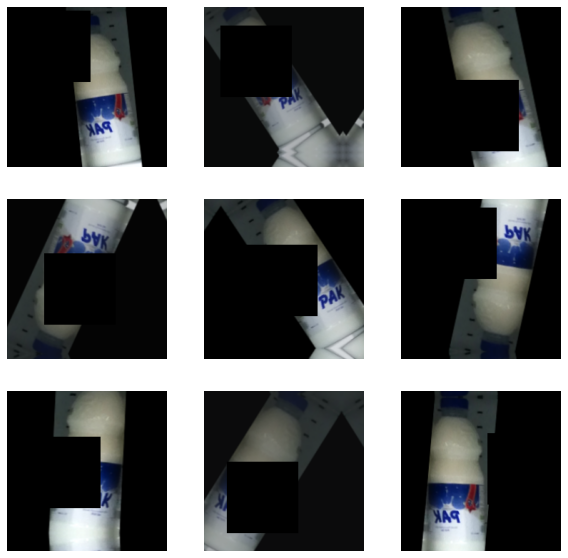

In [116]:
plt.figure(figsize=(10, 10))
for images, label in list(zip(data['x_train'], data['y_train']))[0:1]:
    print('1')
    for i in range(9):
#         images = preprocess_input(images)
        img = np.expand_dims(images,axis=0)
        augmented_images = data_augmentation(img)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")